# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [15]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

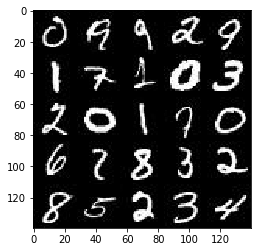

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

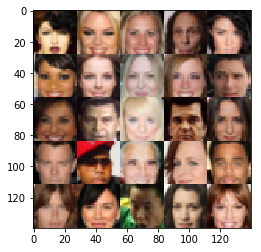

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [19]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    img_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    img_z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32)

    return img_real, img_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [20]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding="same")
        x1 = tf.maximum(alpha*x1, x1)
        
        # now  14*14*64
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        # now 7*7*128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        # now 4*4*256
        
        x3_shape = x3.get_shape().as_list()
        
        flat = tf.reshape(x3, (-1, x3_shape[1]*x3_shape[2]*x3_shape[3]))
        logits = tf.layers.dense(flat, 1)
        
        out = tf.nn.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [21]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse= not is_train):
        # extend to  7*7*256
        x = tf.layers.dense(z, 7*7*256)
        
        # reshape 
        # output size  7*7*256
        x = tf.reshape(x, (-1, 7, 7, 256))
        
        # deconv_1
        # output size 14*14*128
        x1 = tf.layers.conv2d_transpose(x, 128, 5, 2, padding='same')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)

        
        # deconv_2
        # output size  28*28*64
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, 2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
                
        # deconv_3
        # output size 28*28*out_channel_dim
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, 1, padding='same')
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_out = generator(input_z, out_channel_dim, True)
    d_out_real, d_logits_real = discriminator(input_real)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.figure()
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, show_every_epoch=False, show_loss_detail=True):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    
    losses = []
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    train_d_opt, train_g_opt = model_opt(d_loss, g_loss, lr, beta1)
    print()
    print("----------****** Learning Rate {} ... Beta1 {} *****----------".format(learning_rate, beta1))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *=2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(train_d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(train_g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                if steps % 10 == 0 :
                    train_d_loss = d_loss.eval({input_real: batch_images, input_z: batch_z}) 
                    train_g_loss = g_loss.eval({input_z: batch_z})
                    
                    losses.append((train_d_loss, train_g_loss))
                    if show_loss_detail:
                        print("Epoch {}/{} Step {}".format(epoch_i+1, epoch_count, steps), 
                              'Generator Loss: {:.4f}...'.format(train_g_loss), 'Discriminator Loss: {:.4f}'.format(train_d_loss) )
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
            if show_every_epoch:
                print()
                print("Epoch {} end image".format(epoch_i+1))
                show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
            print("*********** Epoch {} Ends *************".format(epoch_i+1))
            
    return losses
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

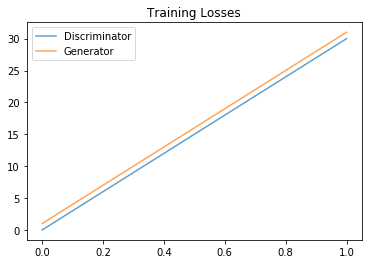

In [26]:
def plot_losses(losses):
    pyplot.figure()
    losses = np.array(losses)
    
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.7)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.7)
    pyplot.title("Training Losses")
    pyplot.legend()

# test
losses = [[x for x in range(0, 20, 1)], [x for x in range(30,50,1)]]
plot_losses(losses)


----------****** Learning Rate 0.001 ... Beta1 0.5 *****----------
Epoch 1/2 Step 10 Generator Loss: 17.2580... Discriminator Loss: 0.0000
Epoch 1/2 Step 20 Generator Loss: 1.4820... Discriminator Loss: 1.8284
Epoch 1/2 Step 30 Generator Loss: 2.0459... Discriminator Loss: 0.5740
Epoch 1/2 Step 40 Generator Loss: 0.5792... Discriminator Loss: 1.3143
Epoch 1/2 Step 50 Generator Loss: 1.2691... Discriminator Loss: 1.0659
Epoch 1/2 Step 60 Generator Loss: 0.8128... Discriminator Loss: 1.3482
Epoch 1/2 Step 70 Generator Loss: 0.3746... Discriminator Loss: 1.6693
Epoch 1/2 Step 80 Generator Loss: 0.6626... Discriminator Loss: 1.2150
Epoch 1/2 Step 90 Generator Loss: 1.3766... Discriminator Loss: 1.2980
Epoch 1/2 Step 100 Generator Loss: 1.3238... Discriminator Loss: 1.2506


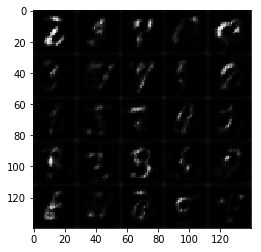

Epoch 1/2 Step 110 Generator Loss: 0.9822... Discriminator Loss: 1.4340
Epoch 1/2 Step 120 Generator Loss: 0.6331... Discriminator Loss: 1.5152
Epoch 1/2 Step 130 Generator Loss: 1.0116... Discriminator Loss: 1.1110
Epoch 1/2 Step 140 Generator Loss: 1.9659... Discriminator Loss: 1.8481
Epoch 1/2 Step 150 Generator Loss: 0.7406... Discriminator Loss: 1.2806
Epoch 1/2 Step 160 Generator Loss: 0.4765... Discriminator Loss: 1.2768
Epoch 1/2 Step 170 Generator Loss: 0.4002... Discriminator Loss: 1.5038
Epoch 1/2 Step 180 Generator Loss: 0.5391... Discriminator Loss: 1.3806
Epoch 1/2 Step 190 Generator Loss: 1.2840... Discriminator Loss: 1.1056
Epoch 1/2 Step 200 Generator Loss: 1.7912... Discriminator Loss: 1.6471


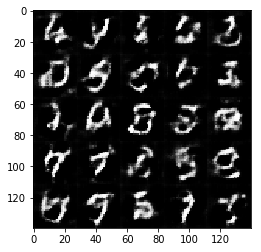

Epoch 1/2 Step 210 Generator Loss: 0.6561... Discriminator Loss: 1.1418
Epoch 1/2 Step 220 Generator Loss: 1.0837... Discriminator Loss: 1.1073
Epoch 1/2 Step 230 Generator Loss: 1.3127... Discriminator Loss: 1.0947
Epoch 1/2 Step 240 Generator Loss: 0.3039... Discriminator Loss: 1.6594
Epoch 1/2 Step 250 Generator Loss: 0.4428... Discriminator Loss: 1.4186
Epoch 1/2 Step 260 Generator Loss: 1.6693... Discriminator Loss: 1.3173
Epoch 1/2 Step 270 Generator Loss: 1.5112... Discriminator Loss: 1.2419
Epoch 1/2 Step 280 Generator Loss: 0.4784... Discriminator Loss: 1.3110
Epoch 1/2 Step 290 Generator Loss: 0.9227... Discriminator Loss: 1.1406
Epoch 1/2 Step 300 Generator Loss: 0.1430... Discriminator Loss: 2.3377


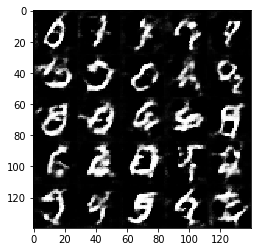

Epoch 1/2 Step 310 Generator Loss: 0.8585... Discriminator Loss: 1.0279
Epoch 1/2 Step 320 Generator Loss: 1.8571... Discriminator Loss: 1.2470
Epoch 1/2 Step 330 Generator Loss: 0.5038... Discriminator Loss: 1.2632
Epoch 1/2 Step 340 Generator Loss: 0.5761... Discriminator Loss: 1.2197
Epoch 1/2 Step 350 Generator Loss: 1.0655... Discriminator Loss: 1.1124
Epoch 1/2 Step 360 Generator Loss: 0.2935... Discriminator Loss: 1.6217
Epoch 1/2 Step 370 Generator Loss: 0.9682... Discriminator Loss: 1.0530
Epoch 1/2 Step 380 Generator Loss: 1.3198... Discriminator Loss: 1.1202
Epoch 1/2 Step 390 Generator Loss: 0.5863... Discriminator Loss: 1.1878
Epoch 1/2 Step 400 Generator Loss: 0.9561... Discriminator Loss: 1.0504


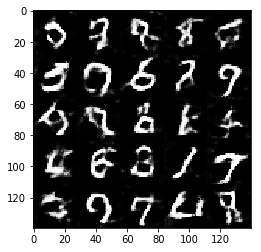

Epoch 1/2 Step 410 Generator Loss: 1.5463... Discriminator Loss: 1.2588
Epoch 1/2 Step 420 Generator Loss: 1.1599... Discriminator Loss: 1.0770
Epoch 1/2 Step 430 Generator Loss: 0.7806... Discriminator Loss: 1.0732
Epoch 1/2 Step 440 Generator Loss: 0.7406... Discriminator Loss: 1.1447
Epoch 1/2 Step 450 Generator Loss: 0.7878... Discriminator Loss: 1.1247
Epoch 1/2 Step 460 Generator Loss: 0.4243... Discriminator Loss: 1.3721

Epoch 1 end image


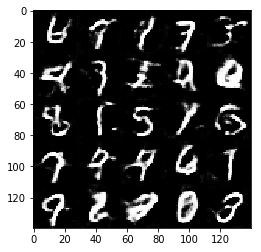

*********** Epoch 1 Ends *************
Epoch 2/2 Step 10 Generator Loss: 1.9122... Discriminator Loss: 1.2616
Epoch 2/2 Step 20 Generator Loss: 0.7483... Discriminator Loss: 0.9595
Epoch 2/2 Step 30 Generator Loss: 0.9999... Discriminator Loss: 0.9937
Epoch 2/2 Step 40 Generator Loss: 0.6778... Discriminator Loss: 1.0544
Epoch 2/2 Step 50 Generator Loss: 0.5701... Discriminator Loss: 1.1328
Epoch 2/2 Step 60 Generator Loss: 0.4471... Discriminator Loss: 1.2571
Epoch 2/2 Step 70 Generator Loss: 1.2554... Discriminator Loss: 1.0163
Epoch 2/2 Step 80 Generator Loss: 0.5793... Discriminator Loss: 1.0996
Epoch 2/2 Step 90 Generator Loss: 1.0812... Discriminator Loss: 1.1328
Epoch 2/2 Step 100 Generator Loss: 1.0305... Discriminator Loss: 1.0896


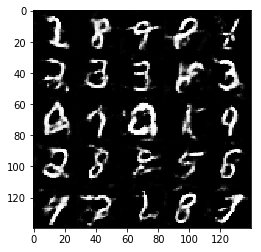

Epoch 2/2 Step 110 Generator Loss: 0.3850... Discriminator Loss: 1.4228
Epoch 2/2 Step 120 Generator Loss: 0.5488... Discriminator Loss: 1.1060
Epoch 2/2 Step 130 Generator Loss: 1.1354... Discriminator Loss: 1.2291
Epoch 2/2 Step 140 Generator Loss: 0.5616... Discriminator Loss: 1.1129
Epoch 2/2 Step 150 Generator Loss: 1.0538... Discriminator Loss: 0.8159
Epoch 2/2 Step 160 Generator Loss: 1.4082... Discriminator Loss: 0.8047
Epoch 2/2 Step 170 Generator Loss: 0.8632... Discriminator Loss: 0.9065
Epoch 2/2 Step 180 Generator Loss: 1.2850... Discriminator Loss: 0.8378
Epoch 2/2 Step 190 Generator Loss: 4.5883... Discriminator Loss: 3.3662
Epoch 2/2 Step 200 Generator Loss: 0.7661... Discriminator Loss: 1.0952


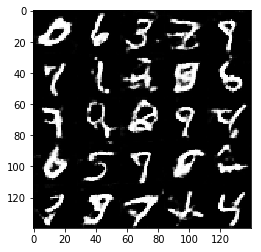

Epoch 2/2 Step 210 Generator Loss: 0.9589... Discriminator Loss: 0.8930
Epoch 2/2 Step 220 Generator Loss: 0.7631... Discriminator Loss: 0.8984
Epoch 2/2 Step 230 Generator Loss: 0.1610... Discriminator Loss: 2.3059
Epoch 2/2 Step 240 Generator Loss: 0.9251... Discriminator Loss: 0.8387
Epoch 2/2 Step 250 Generator Loss: 1.7404... Discriminator Loss: 1.0544
Epoch 2/2 Step 260 Generator Loss: 1.0373... Discriminator Loss: 0.8940
Epoch 2/2 Step 270 Generator Loss: 0.8458... Discriminator Loss: 0.9444
Epoch 2/2 Step 280 Generator Loss: 0.5498... Discriminator Loss: 1.2858
Epoch 2/2 Step 290 Generator Loss: 1.0820... Discriminator Loss: 0.8879
Epoch 2/2 Step 300 Generator Loss: 1.3079... Discriminator Loss: 0.7997


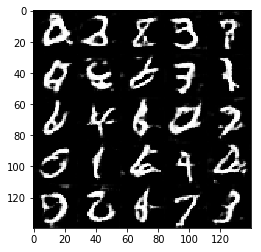

Epoch 2/2 Step 310 Generator Loss: 0.8044... Discriminator Loss: 0.9440
Epoch 2/2 Step 320 Generator Loss: 1.0927... Discriminator Loss: 0.9322
Epoch 2/2 Step 330 Generator Loss: 1.5646... Discriminator Loss: 0.7965
Epoch 2/2 Step 340 Generator Loss: 1.4887... Discriminator Loss: 0.6289
Epoch 2/2 Step 350 Generator Loss: 0.8091... Discriminator Loss: 0.8394
Epoch 2/2 Step 360 Generator Loss: 1.8627... Discriminator Loss: 0.7507
Epoch 2/2 Step 370 Generator Loss: 1.7732... Discriminator Loss: 0.8539
Epoch 2/2 Step 380 Generator Loss: 0.9050... Discriminator Loss: 1.0099
Epoch 2/2 Step 390 Generator Loss: 0.8916... Discriminator Loss: 0.8473
Epoch 2/2 Step 400 Generator Loss: 0.7974... Discriminator Loss: 0.9481


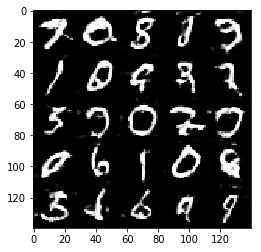

Epoch 2/2 Step 410 Generator Loss: 0.5320... Discriminator Loss: 1.2749
Epoch 2/2 Step 420 Generator Loss: 1.0191... Discriminator Loss: 0.8653
Epoch 2/2 Step 430 Generator Loss: 1.5784... Discriminator Loss: 0.5645
Epoch 2/2 Step 440 Generator Loss: 3.7770... Discriminator Loss: 1.1937
Epoch 2/2 Step 450 Generator Loss: 1.1264... Discriminator Loss: 0.8874
Epoch 2/2 Step 460 Generator Loss: 0.4796... Discriminator Loss: 1.3282

Epoch 2 end image


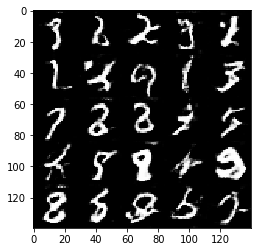

*********** Epoch 2 Ends *************


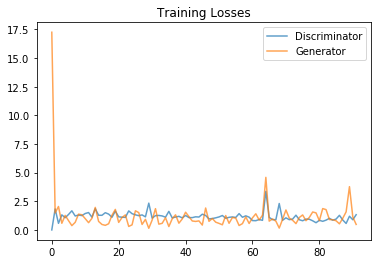

In [27]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, show_every_epoch=True, show_loss_detail=True)
    plot_losses(losses)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。


----------****** Learning Rate 0.001 ... Beta1 0.5 *****----------
Epoch 1/5 Step 10 Generator Loss: 16.3436... Discriminator Loss: 0.1672
Epoch 1/5 Step 20 Generator Loss: 3.0769... Discriminator Loss: 0.3248
Epoch 1/5 Step 30 Generator Loss: 4.6396... Discriminator Loss: 0.7638
Epoch 1/5 Step 40 Generator Loss: 0.1627... Discriminator Loss: 2.4601
Epoch 1/5 Step 50 Generator Loss: 2.1048... Discriminator Loss: 0.8067
Epoch 1/5 Step 60 Generator Loss: 0.3927... Discriminator Loss: 1.5922
Epoch 1/5 Step 70 Generator Loss: 0.1671... Discriminator Loss: 2.3503
Epoch 1/5 Step 80 Generator Loss: 2.3395... Discriminator Loss: 0.4728
Epoch 1/5 Step 90 Generator Loss: 0.4061... Discriminator Loss: 1.5892
Epoch 1/5 Step 100 Generator Loss: 1.1656... Discriminator Loss: 1.3341


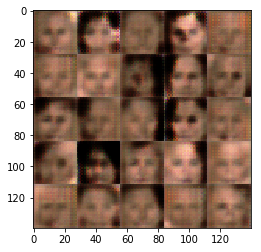

Epoch 1/5 Step 110 Generator Loss: 1.6717... Discriminator Loss: 1.4660
Epoch 1/5 Step 120 Generator Loss: 1.2074... Discriminator Loss: 0.7638
Epoch 1/5 Step 130 Generator Loss: 3.6425... Discriminator Loss: 3.2963
Epoch 1/5 Step 140 Generator Loss: 1.9460... Discriminator Loss: 1.4897
Epoch 1/5 Step 150 Generator Loss: 2.9246... Discriminator Loss: 1.2211
Epoch 1/5 Step 160 Generator Loss: 0.9231... Discriminator Loss: 0.8366
Epoch 1/5 Step 170 Generator Loss: 0.3042... Discriminator Loss: 1.6712
Epoch 1/5 Step 180 Generator Loss: 0.6979... Discriminator Loss: 0.9775
Epoch 1/5 Step 190 Generator Loss: 0.2682... Discriminator Loss: 1.6545
Epoch 1/5 Step 200 Generator Loss: 1.4259... Discriminator Loss: 1.3805


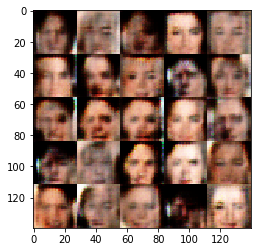

Epoch 1/5 Step 210 Generator Loss: 1.5578... Discriminator Loss: 0.5836
Epoch 1/5 Step 220 Generator Loss: 0.6283... Discriminator Loss: 1.0104
Epoch 1/5 Step 230 Generator Loss: 0.3959... Discriminator Loss: 1.4691
Epoch 1/5 Step 240 Generator Loss: 1.1045... Discriminator Loss: 0.9267
Epoch 1/5 Step 250 Generator Loss: 2.6064... Discriminator Loss: 2.3436
Epoch 1/5 Step 260 Generator Loss: 1.6913... Discriminator Loss: 0.7248
Epoch 1/5 Step 270 Generator Loss: 1.1389... Discriminator Loss: 1.2150
Epoch 1/5 Step 280 Generator Loss: 0.8886... Discriminator Loss: 0.9129
Epoch 1/5 Step 290 Generator Loss: 0.3311... Discriminator Loss: 1.4751
Epoch 1/5 Step 300 Generator Loss: 3.2253... Discriminator Loss: 2.9602


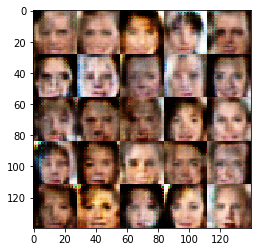

Epoch 1/5 Step 310 Generator Loss: 0.1941... Discriminator Loss: 2.1415
Epoch 1/5 Step 320 Generator Loss: 1.3061... Discriminator Loss: 0.7270
Epoch 1/5 Step 330 Generator Loss: 0.9750... Discriminator Loss: 1.3848
Epoch 1/5 Step 340 Generator Loss: 0.6277... Discriminator Loss: 1.0130
Epoch 1/5 Step 350 Generator Loss: 2.0129... Discriminator Loss: 1.2825
Epoch 1/5 Step 360 Generator Loss: 1.3115... Discriminator Loss: 1.4881
Epoch 1/5 Step 370 Generator Loss: 0.7598... Discriminator Loss: 1.2137
Epoch 1/5 Step 380 Generator Loss: 1.3639... Discriminator Loss: 0.5737
Epoch 1/5 Step 390 Generator Loss: 1.1153... Discriminator Loss: 1.4114
Epoch 1/5 Step 400 Generator Loss: 0.2687... Discriminator Loss: 1.6921


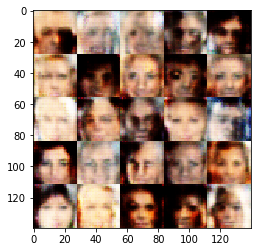

Epoch 1/5 Step 410 Generator Loss: 0.8648... Discriminator Loss: 1.2607
Epoch 1/5 Step 420 Generator Loss: 1.6825... Discriminator Loss: 1.2875
Epoch 1/5 Step 430 Generator Loss: 0.6360... Discriminator Loss: 0.9794
Epoch 1/5 Step 440 Generator Loss: 1.4425... Discriminator Loss: 1.7436
Epoch 1/5 Step 450 Generator Loss: 0.3841... Discriminator Loss: 1.4482
Epoch 1/5 Step 460 Generator Loss: 0.4155... Discriminator Loss: 1.4069
Epoch 1/5 Step 470 Generator Loss: 0.8101... Discriminator Loss: 1.0225
Epoch 1/5 Step 480 Generator Loss: 1.0945... Discriminator Loss: 0.7644
Epoch 1/5 Step 490 Generator Loss: 0.3936... Discriminator Loss: 1.5717
Epoch 1/5 Step 500 Generator Loss: 2.9260... Discriminator Loss: 1.8741


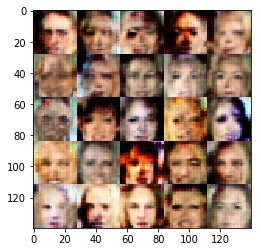

Epoch 1/5 Step 510 Generator Loss: 1.7637... Discriminator Loss: 0.8740
Epoch 1/5 Step 520 Generator Loss: 2.1336... Discriminator Loss: 0.9191
Epoch 1/5 Step 530 Generator Loss: 3.2890... Discriminator Loss: 0.6236
Epoch 1/5 Step 540 Generator Loss: 0.4468... Discriminator Loss: 1.2601
Epoch 1/5 Step 550 Generator Loss: 1.2697... Discriminator Loss: 0.7341
Epoch 1/5 Step 560 Generator Loss: 0.3703... Discriminator Loss: 1.4825
Epoch 1/5 Step 570 Generator Loss: 1.1139... Discriminator Loss: 0.7657
Epoch 1/5 Step 580 Generator Loss: 2.6958... Discriminator Loss: 1.7514
Epoch 1/5 Step 590 Generator Loss: 0.7638... Discriminator Loss: 0.8791
Epoch 1/5 Step 600 Generator Loss: 2.4703... Discriminator Loss: 1.4121


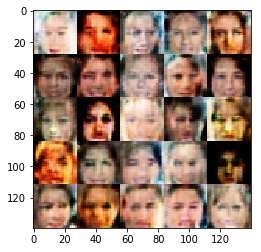

Epoch 1/5 Step 610 Generator Loss: 1.7505... Discriminator Loss: 1.8117
Epoch 1/5 Step 620 Generator Loss: 1.4835... Discriminator Loss: 0.5319
Epoch 1/5 Step 630 Generator Loss: 0.6606... Discriminator Loss: 1.2349
Epoch 1/5 Step 640 Generator Loss: 1.0941... Discriminator Loss: 1.0826
Epoch 1/5 Step 650 Generator Loss: 0.4679... Discriminator Loss: 1.2370
Epoch 1/5 Step 660 Generator Loss: 1.2621... Discriminator Loss: 0.7148
Epoch 1/5 Step 670 Generator Loss: 1.6479... Discriminator Loss: 0.4973
Epoch 1/5 Step 680 Generator Loss: 0.5677... Discriminator Loss: 1.0420
Epoch 1/5 Step 690 Generator Loss: 1.2172... Discriminator Loss: 0.6423
Epoch 1/5 Step 700 Generator Loss: 1.2413... Discriminator Loss: 1.2555


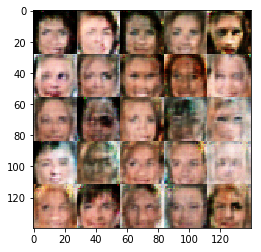

Epoch 1/5 Step 710 Generator Loss: 0.9795... Discriminator Loss: 0.7550
Epoch 1/5 Step 720 Generator Loss: 1.2110... Discriminator Loss: 1.4997
Epoch 1/5 Step 730 Generator Loss: 2.3199... Discriminator Loss: 0.7140
Epoch 1/5 Step 740 Generator Loss: 1.5944... Discriminator Loss: 0.8073
Epoch 1/5 Step 750 Generator Loss: 1.9936... Discriminator Loss: 1.3964
Epoch 1/5 Step 760 Generator Loss: 1.1339... Discriminator Loss: 1.1279
Epoch 1/5 Step 770 Generator Loss: 1.2126... Discriminator Loss: 0.5686
Epoch 1/5 Step 780 Generator Loss: 0.3083... Discriminator Loss: 1.5609
Epoch 1/5 Step 790 Generator Loss: 1.0241... Discriminator Loss: 1.0072
Epoch 1/5 Step 800 Generator Loss: 0.5700... Discriminator Loss: 1.1225


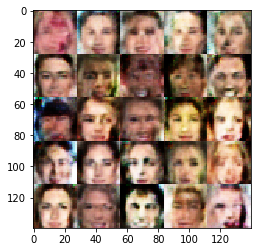

Epoch 1/5 Step 810 Generator Loss: 1.1973... Discriminator Loss: 0.7201
Epoch 1/5 Step 820 Generator Loss: 3.4051... Discriminator Loss: 2.8080
Epoch 1/5 Step 830 Generator Loss: 1.2273... Discriminator Loss: 1.1847
Epoch 1/5 Step 840 Generator Loss: 0.6184... Discriminator Loss: 1.0397
Epoch 1/5 Step 850 Generator Loss: 0.8296... Discriminator Loss: 0.8813
Epoch 1/5 Step 860 Generator Loss: 0.8230... Discriminator Loss: 0.9962
Epoch 1/5 Step 870 Generator Loss: 0.5209... Discriminator Loss: 1.1564
Epoch 1/5 Step 880 Generator Loss: 2.0592... Discriminator Loss: 1.0372
Epoch 1/5 Step 890 Generator Loss: 0.5947... Discriminator Loss: 1.0189
Epoch 1/5 Step 900 Generator Loss: 1.9694... Discriminator Loss: 0.4165


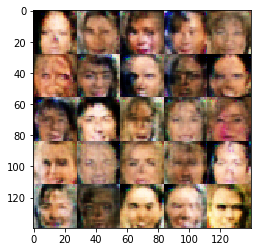

Epoch 1/5 Step 910 Generator Loss: 3.5635... Discriminator Loss: 3.0676
Epoch 1/5 Step 920 Generator Loss: 1.2075... Discriminator Loss: 1.0354
Epoch 1/5 Step 930 Generator Loss: 0.5050... Discriminator Loss: 1.1788
Epoch 1/5 Step 940 Generator Loss: 0.4747... Discriminator Loss: 1.4337
Epoch 1/5 Step 950 Generator Loss: 1.1577... Discriminator Loss: 0.6841
Epoch 1/5 Step 960 Generator Loss: 0.5266... Discriminator Loss: 1.2095
Epoch 1/5 Step 970 Generator Loss: 0.7974... Discriminator Loss: 1.4697
Epoch 1/5 Step 980 Generator Loss: 0.4291... Discriminator Loss: 1.4414
Epoch 1/5 Step 990 Generator Loss: 0.8767... Discriminator Loss: 1.0681
Epoch 1/5 Step 1000 Generator Loss: 2.1053... Discriminator Loss: 1.7194


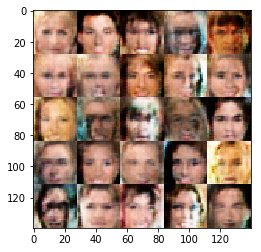

Epoch 1/5 Step 1010 Generator Loss: 1.2965... Discriminator Loss: 1.2443
Epoch 1/5 Step 1020 Generator Loss: 1.2477... Discriminator Loss: 0.7867
Epoch 1/5 Step 1030 Generator Loss: 1.3824... Discriminator Loss: 0.9533
Epoch 1/5 Step 1040 Generator Loss: 0.6481... Discriminator Loss: 1.2675
Epoch 1/5 Step 1050 Generator Loss: 0.5785... Discriminator Loss: 1.0863
Epoch 1/5 Step 1060 Generator Loss: 0.4477... Discriminator Loss: 1.5652
Epoch 1/5 Step 1070 Generator Loss: 1.2297... Discriminator Loss: 0.8497
Epoch 1/5 Step 1080 Generator Loss: 0.4654... Discriminator Loss: 1.5281
Epoch 1/5 Step 1090 Generator Loss: 0.4210... Discriminator Loss: 1.3954
Epoch 1/5 Step 1100 Generator Loss: 1.1102... Discriminator Loss: 1.1648


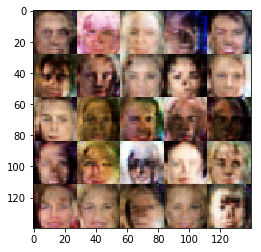

Epoch 1/5 Step 1110 Generator Loss: 0.7546... Discriminator Loss: 1.2130
Epoch 1/5 Step 1120 Generator Loss: 0.5663... Discriminator Loss: 1.2119
Epoch 1/5 Step 1130 Generator Loss: 0.9251... Discriminator Loss: 0.7454
Epoch 1/5 Step 1140 Generator Loss: 0.3759... Discriminator Loss: 1.3693
Epoch 1/5 Step 1150 Generator Loss: 1.5773... Discriminator Loss: 1.0502
Epoch 1/5 Step 1160 Generator Loss: 1.0397... Discriminator Loss: 1.2435
Epoch 1/5 Step 1170 Generator Loss: 1.2408... Discriminator Loss: 1.6250
Epoch 1/5 Step 1180 Generator Loss: 0.6866... Discriminator Loss: 1.2163
Epoch 1/5 Step 1190 Generator Loss: 0.8750... Discriminator Loss: 1.1821
Epoch 1/5 Step 1200 Generator Loss: 1.4377... Discriminator Loss: 1.4863


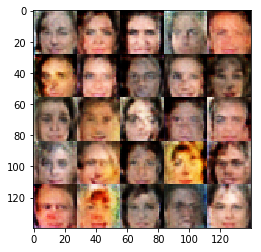

Epoch 1/5 Step 1210 Generator Loss: 0.9300... Discriminator Loss: 1.0995
Epoch 1/5 Step 1220 Generator Loss: 1.1576... Discriminator Loss: 1.2281
Epoch 1/5 Step 1230 Generator Loss: 1.6658... Discriminator Loss: 0.6892
Epoch 1/5 Step 1240 Generator Loss: 1.0086... Discriminator Loss: 1.1882
Epoch 1/5 Step 1250 Generator Loss: 0.1722... Discriminator Loss: 2.2095
Epoch 1/5 Step 1260 Generator Loss: 0.8423... Discriminator Loss: 1.1434
Epoch 1/5 Step 1270 Generator Loss: 1.6290... Discriminator Loss: 1.4686
Epoch 1/5 Step 1280 Generator Loss: 0.8605... Discriminator Loss: 1.2139
Epoch 1/5 Step 1290 Generator Loss: 1.0645... Discriminator Loss: 0.8400
Epoch 1/5 Step 1300 Generator Loss: 1.1537... Discriminator Loss: 1.1433


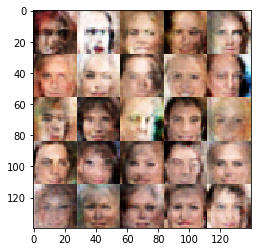

Epoch 1/5 Step 1310 Generator Loss: 2.0733... Discriminator Loss: 1.5347
Epoch 1/5 Step 1320 Generator Loss: 0.4002... Discriminator Loss: 1.5493
Epoch 1/5 Step 1330 Generator Loss: 0.6817... Discriminator Loss: 1.2471
Epoch 1/5 Step 1340 Generator Loss: 0.3810... Discriminator Loss: 1.5744
Epoch 1/5 Step 1350 Generator Loss: 2.3303... Discriminator Loss: 0.5870
Epoch 1/5 Step 1360 Generator Loss: 0.8378... Discriminator Loss: 1.3023
Epoch 1/5 Step 1370 Generator Loss: 0.8289... Discriminator Loss: 1.1599
Epoch 1/5 Step 1380 Generator Loss: 0.9167... Discriminator Loss: 1.0706
Epoch 1/5 Step 1390 Generator Loss: 0.6444... Discriminator Loss: 1.2628
Epoch 1/5 Step 1400 Generator Loss: 1.8563... Discriminator Loss: 0.8875


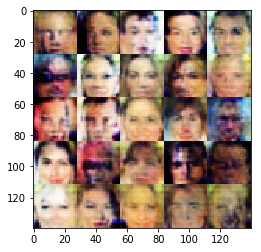

Epoch 1/5 Step 1410 Generator Loss: 1.3953... Discriminator Loss: 1.1491
Epoch 1/5 Step 1420 Generator Loss: 0.5736... Discriminator Loss: 1.3058
Epoch 1/5 Step 1430 Generator Loss: 0.7635... Discriminator Loss: 1.3034
Epoch 1/5 Step 1440 Generator Loss: 1.3079... Discriminator Loss: 1.1081
Epoch 1/5 Step 1450 Generator Loss: 1.0556... Discriminator Loss: 1.3167
Epoch 1/5 Step 1460 Generator Loss: 1.4951... Discriminator Loss: 0.8184
Epoch 1/5 Step 1470 Generator Loss: 0.8010... Discriminator Loss: 1.1255
Epoch 1/5 Step 1480 Generator Loss: 1.4667... Discriminator Loss: 0.8982
Epoch 1/5 Step 1490 Generator Loss: 1.2276... Discriminator Loss: 0.6074
Epoch 1/5 Step 1500 Generator Loss: 2.2942... Discriminator Loss: 0.7630


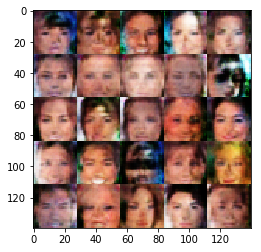

Epoch 1/5 Step 1510 Generator Loss: 1.1284... Discriminator Loss: 0.9968
Epoch 1/5 Step 1520 Generator Loss: 1.6777... Discriminator Loss: 0.8349
Epoch 1/5 Step 1530 Generator Loss: 2.7163... Discriminator Loss: 0.7467
Epoch 1/5 Step 1540 Generator Loss: 0.7949... Discriminator Loss: 0.8950
Epoch 1/5 Step 1550 Generator Loss: 0.4060... Discriminator Loss: 1.4317
Epoch 1/5 Step 1560 Generator Loss: 1.2224... Discriminator Loss: 0.6600
Epoch 1/5 Step 1570 Generator Loss: 0.8296... Discriminator Loss: 1.2840
Epoch 1/5 Step 1580 Generator Loss: 0.7851... Discriminator Loss: 1.3086
*********** Epoch 1 Ends *************
Epoch 2/5 Step 10 Generator Loss: 0.8312... Discriminator Loss: 1.1160
Epoch 2/5 Step 20 Generator Loss: 0.9230... Discriminator Loss: 1.1231
Epoch 2/5 Step 30 Generator Loss: 1.0014... Discriminator Loss: 0.8374
Epoch 2/5 Step 40 Generator Loss: 0.7490... Discriminator Loss: 1.2716
Epoch 2/5 Step 50 Generator Loss: 0.1402... Discriminator Loss: 2.2373
Epoch 2/5 Step 60 Gene

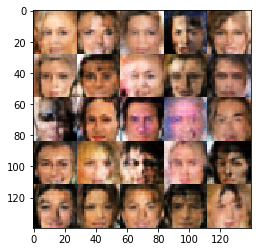

Epoch 2/5 Step 110 Generator Loss: 0.7109... Discriminator Loss: 1.3028
Epoch 2/5 Step 120 Generator Loss: 0.5593... Discriminator Loss: 1.2794
Epoch 2/5 Step 130 Generator Loss: 0.9976... Discriminator Loss: 1.1938
Epoch 2/5 Step 140 Generator Loss: 0.8308... Discriminator Loss: 1.2536
Epoch 2/5 Step 150 Generator Loss: 0.5729... Discriminator Loss: 1.2845
Epoch 2/5 Step 160 Generator Loss: 0.9549... Discriminator Loss: 1.3093
Epoch 2/5 Step 170 Generator Loss: 0.5585... Discriminator Loss: 1.3363
Epoch 2/5 Step 180 Generator Loss: 1.2136... Discriminator Loss: 1.3168
Epoch 2/5 Step 190 Generator Loss: 0.8185... Discriminator Loss: 0.9918
Epoch 2/5 Step 200 Generator Loss: 0.4898... Discriminator Loss: 1.3632


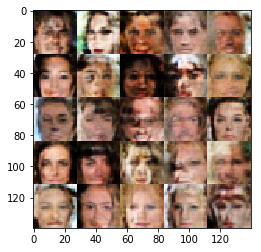

Epoch 2/5 Step 210 Generator Loss: 1.9939... Discriminator Loss: 1.2102
Epoch 2/5 Step 220 Generator Loss: 0.8654... Discriminator Loss: 1.0678
Epoch 2/5 Step 230 Generator Loss: 0.7057... Discriminator Loss: 1.3036
Epoch 2/5 Step 240 Generator Loss: 0.5371... Discriminator Loss: 1.2751
Epoch 2/5 Step 250 Generator Loss: 0.7928... Discriminator Loss: 1.0298
Epoch 2/5 Step 260 Generator Loss: 2.0328... Discriminator Loss: 1.3600
Epoch 2/5 Step 270 Generator Loss: 0.5587... Discriminator Loss: 1.1769
Epoch 2/5 Step 280 Generator Loss: 0.7460... Discriminator Loss: 1.1427
Epoch 2/5 Step 290 Generator Loss: 0.3734... Discriminator Loss: 1.5207
Epoch 2/5 Step 300 Generator Loss: 1.4154... Discriminator Loss: 0.6974


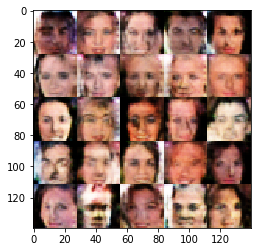

Epoch 2/5 Step 310 Generator Loss: 1.3365... Discriminator Loss: 0.9204
Epoch 2/5 Step 320 Generator Loss: 0.6316... Discriminator Loss: 1.2156
Epoch 2/5 Step 330 Generator Loss: 1.3301... Discriminator Loss: 1.2996
Epoch 2/5 Step 340 Generator Loss: 0.7599... Discriminator Loss: 1.1473
Epoch 2/5 Step 350 Generator Loss: 0.5257... Discriminator Loss: 1.2637
Epoch 2/5 Step 360 Generator Loss: 1.1478... Discriminator Loss: 0.8089
Epoch 2/5 Step 370 Generator Loss: 2.8167... Discriminator Loss: 0.8377
Epoch 2/5 Step 380 Generator Loss: 0.8362... Discriminator Loss: 0.9420
Epoch 2/5 Step 390 Generator Loss: 1.4084... Discriminator Loss: 1.2366
Epoch 2/5 Step 400 Generator Loss: 0.5857... Discriminator Loss: 1.1648


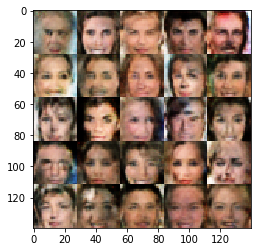

Epoch 2/5 Step 410 Generator Loss: 1.7241... Discriminator Loss: 1.8110
Epoch 2/5 Step 420 Generator Loss: 1.5084... Discriminator Loss: 0.8629
Epoch 2/5 Step 430 Generator Loss: 0.2267... Discriminator Loss: 1.8768
Epoch 2/5 Step 440 Generator Loss: 0.9129... Discriminator Loss: 0.9820
Epoch 2/5 Step 450 Generator Loss: 1.7912... Discriminator Loss: 1.0620
Epoch 2/5 Step 460 Generator Loss: 1.0460... Discriminator Loss: 1.1066
Epoch 2/5 Step 470 Generator Loss: 0.6114... Discriminator Loss: 1.4795
Epoch 2/5 Step 480 Generator Loss: 0.7450... Discriminator Loss: 1.1524
Epoch 2/5 Step 490 Generator Loss: 0.3977... Discriminator Loss: 1.5427
Epoch 2/5 Step 500 Generator Loss: 1.3143... Discriminator Loss: 1.1609


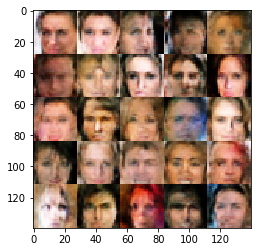

Epoch 2/5 Step 510 Generator Loss: 0.8976... Discriminator Loss: 1.3560
Epoch 2/5 Step 520 Generator Loss: 0.8369... Discriminator Loss: 1.1342
Epoch 2/5 Step 530 Generator Loss: 0.7781... Discriminator Loss: 1.3585
Epoch 2/5 Step 540 Generator Loss: 1.5080... Discriminator Loss: 0.9813
Epoch 2/5 Step 550 Generator Loss: 1.3763... Discriminator Loss: 1.2452
Epoch 2/5 Step 560 Generator Loss: 1.4830... Discriminator Loss: 0.8960
Epoch 2/5 Step 570 Generator Loss: 1.0036... Discriminator Loss: 0.7930
Epoch 2/5 Step 580 Generator Loss: 0.6935... Discriminator Loss: 1.0224
Epoch 2/5 Step 590 Generator Loss: 0.8233... Discriminator Loss: 1.1604
Epoch 2/5 Step 600 Generator Loss: 0.8178... Discriminator Loss: 1.2036


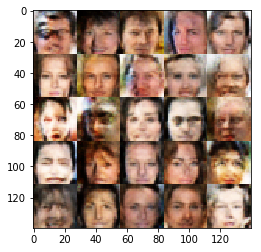

Epoch 2/5 Step 610 Generator Loss: 0.6921... Discriminator Loss: 1.1295
Epoch 2/5 Step 620 Generator Loss: 0.2684... Discriminator Loss: 1.7091
Epoch 2/5 Step 630 Generator Loss: 0.6158... Discriminator Loss: 1.2261
Epoch 2/5 Step 640 Generator Loss: 0.5828... Discriminator Loss: 1.3268
Epoch 2/5 Step 650 Generator Loss: 1.8690... Discriminator Loss: 1.6784
Epoch 2/5 Step 660 Generator Loss: 0.6740... Discriminator Loss: 1.2127
Epoch 2/5 Step 670 Generator Loss: 1.6831... Discriminator Loss: 1.3613
Epoch 2/5 Step 680 Generator Loss: 2.3522... Discriminator Loss: 1.2098
Epoch 2/5 Step 690 Generator Loss: 1.8400... Discriminator Loss: 1.4280
Epoch 2/5 Step 700 Generator Loss: 1.2781... Discriminator Loss: 0.8218


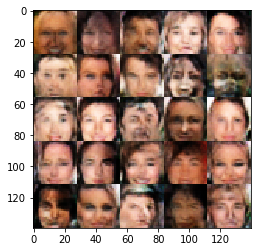

Epoch 2/5 Step 710 Generator Loss: 1.9060... Discriminator Loss: 0.7353
Epoch 2/5 Step 720 Generator Loss: 0.7493... Discriminator Loss: 0.9999
Epoch 2/5 Step 730 Generator Loss: 1.0155... Discriminator Loss: 1.1380
Epoch 2/5 Step 740 Generator Loss: 0.9481... Discriminator Loss: 0.8761
Epoch 2/5 Step 750 Generator Loss: 0.4386... Discriminator Loss: 1.3481
Epoch 2/5 Step 760 Generator Loss: 0.5911... Discriminator Loss: 1.1115
Epoch 2/5 Step 770 Generator Loss: 0.8399... Discriminator Loss: 1.1608
Epoch 2/5 Step 780 Generator Loss: 0.6634... Discriminator Loss: 1.1100
Epoch 2/5 Step 790 Generator Loss: 0.6210... Discriminator Loss: 1.1989
Epoch 2/5 Step 800 Generator Loss: 1.7417... Discriminator Loss: 1.8997


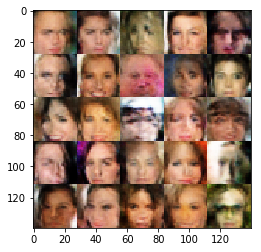

Epoch 2/5 Step 810 Generator Loss: 1.6362... Discriminator Loss: 1.4411
Epoch 2/5 Step 820 Generator Loss: 1.2368... Discriminator Loss: 0.7683
Epoch 2/5 Step 830 Generator Loss: 1.1451... Discriminator Loss: 0.7945
Epoch 2/5 Step 840 Generator Loss: 0.5900... Discriminator Loss: 1.1456
Epoch 2/5 Step 850 Generator Loss: 0.7216... Discriminator Loss: 1.0491
Epoch 2/5 Step 860 Generator Loss: 1.3036... Discriminator Loss: 1.1137
Epoch 2/5 Step 870 Generator Loss: 0.4077... Discriminator Loss: 1.4613
Epoch 2/5 Step 880 Generator Loss: 0.7164... Discriminator Loss: 1.2542
Epoch 2/5 Step 890 Generator Loss: 1.7202... Discriminator Loss: 0.8854
Epoch 2/5 Step 900 Generator Loss: 0.6353... Discriminator Loss: 1.1144


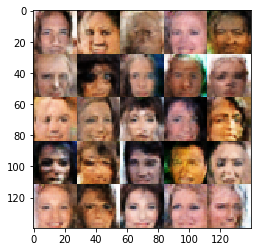

Epoch 2/5 Step 910 Generator Loss: 0.6858... Discriminator Loss: 1.0234
Epoch 2/5 Step 920 Generator Loss: 0.9050... Discriminator Loss: 1.0291
Epoch 2/5 Step 930 Generator Loss: 0.4400... Discriminator Loss: 1.6293
Epoch 2/5 Step 940 Generator Loss: 0.4996... Discriminator Loss: 1.2646
Epoch 2/5 Step 950 Generator Loss: 0.4669... Discriminator Loss: 1.2622
Epoch 2/5 Step 960 Generator Loss: 0.5306... Discriminator Loss: 1.3685
Epoch 2/5 Step 970 Generator Loss: 0.4336... Discriminator Loss: 1.3315
Epoch 2/5 Step 980 Generator Loss: 1.4260... Discriminator Loss: 1.1461
Epoch 2/5 Step 990 Generator Loss: 1.1213... Discriminator Loss: 1.0538
Epoch 2/5 Step 1000 Generator Loss: 1.4629... Discriminator Loss: 1.1364


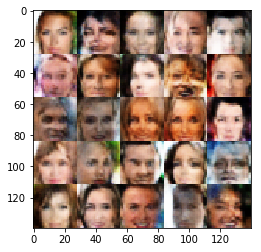

Epoch 2/5 Step 1010 Generator Loss: 1.5617... Discriminator Loss: 1.1718
Epoch 2/5 Step 1020 Generator Loss: 0.6027... Discriminator Loss: 1.0865
Epoch 2/5 Step 1030 Generator Loss: 0.6855... Discriminator Loss: 0.9159
Epoch 2/5 Step 1040 Generator Loss: 0.6555... Discriminator Loss: 1.0930
Epoch 2/5 Step 1050 Generator Loss: 0.8126... Discriminator Loss: 1.2051
Epoch 2/5 Step 1060 Generator Loss: 0.4337... Discriminator Loss: 1.4038
Epoch 2/5 Step 1070 Generator Loss: 0.3048... Discriminator Loss: 1.5842
Epoch 2/5 Step 1080 Generator Loss: 1.3499... Discriminator Loss: 0.7032
Epoch 2/5 Step 1090 Generator Loss: 0.9416... Discriminator Loss: 1.1751
Epoch 2/5 Step 1100 Generator Loss: 0.8550... Discriminator Loss: 1.1761


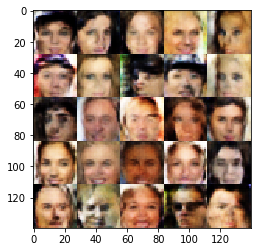

Epoch 2/5 Step 1110 Generator Loss: 1.1776... Discriminator Loss: 0.7150
Epoch 2/5 Step 1120 Generator Loss: 0.9356... Discriminator Loss: 1.0085
Epoch 2/5 Step 1130 Generator Loss: 1.0527... Discriminator Loss: 1.1538
Epoch 2/5 Step 1140 Generator Loss: 0.7404... Discriminator Loss: 1.0226
Epoch 2/5 Step 1150 Generator Loss: 1.5819... Discriminator Loss: 0.9939
Epoch 2/5 Step 1160 Generator Loss: 2.1532... Discriminator Loss: 1.5085
Epoch 2/5 Step 1170 Generator Loss: 1.2581... Discriminator Loss: 0.6481
Epoch 2/5 Step 1180 Generator Loss: 1.5301... Discriminator Loss: 1.0034
Epoch 2/5 Step 1190 Generator Loss: 0.6497... Discriminator Loss: 1.0997
Epoch 2/5 Step 1200 Generator Loss: 1.3870... Discriminator Loss: 1.0136


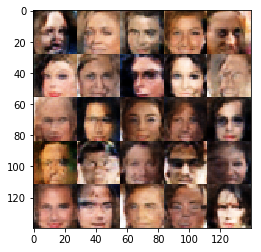

Epoch 2/5 Step 1210 Generator Loss: 1.6135... Discriminator Loss: 1.0954
Epoch 2/5 Step 1220 Generator Loss: 0.6423... Discriminator Loss: 1.1719
Epoch 2/5 Step 1230 Generator Loss: 1.8969... Discriminator Loss: 1.2065
Epoch 2/5 Step 1240 Generator Loss: 1.3050... Discriminator Loss: 1.2144
Epoch 2/5 Step 1250 Generator Loss: 1.2299... Discriminator Loss: 1.0609
Epoch 2/5 Step 1260 Generator Loss: 0.5824... Discriminator Loss: 1.1730
Epoch 2/5 Step 1270 Generator Loss: 1.4943... Discriminator Loss: 1.0417
Epoch 2/5 Step 1280 Generator Loss: 0.6931... Discriminator Loss: 1.1731
Epoch 2/5 Step 1290 Generator Loss: 0.2920... Discriminator Loss: 1.6753
Epoch 2/5 Step 1300 Generator Loss: 0.4229... Discriminator Loss: 1.4322


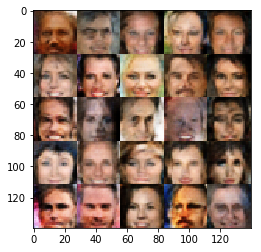

Epoch 2/5 Step 1310 Generator Loss: 1.0472... Discriminator Loss: 1.0327
Epoch 2/5 Step 1320 Generator Loss: 0.3718... Discriminator Loss: 1.4564
Epoch 2/5 Step 1330 Generator Loss: 1.9155... Discriminator Loss: 1.5350
Epoch 2/5 Step 1340 Generator Loss: 0.9270... Discriminator Loss: 1.0421
Epoch 2/5 Step 1350 Generator Loss: 0.4783... Discriminator Loss: 1.4139
Epoch 2/5 Step 1360 Generator Loss: 0.9814... Discriminator Loss: 0.9319
Epoch 2/5 Step 1370 Generator Loss: 0.4817... Discriminator Loss: 1.3356
Epoch 2/5 Step 1380 Generator Loss: 0.7228... Discriminator Loss: 1.0855
Epoch 2/5 Step 1390 Generator Loss: 0.6422... Discriminator Loss: 1.1373
Epoch 2/5 Step 1400 Generator Loss: 0.5631... Discriminator Loss: 1.2370


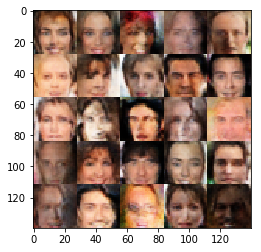

Epoch 2/5 Step 1410 Generator Loss: 0.9389... Discriminator Loss: 0.9182
Epoch 2/5 Step 1420 Generator Loss: 0.9106... Discriminator Loss: 1.1118
Epoch 2/5 Step 1430 Generator Loss: 0.5255... Discriminator Loss: 1.2259
Epoch 2/5 Step 1440 Generator Loss: 1.1746... Discriminator Loss: 1.0036
Epoch 2/5 Step 1450 Generator Loss: 0.8398... Discriminator Loss: 1.0675
Epoch 2/5 Step 1460 Generator Loss: 0.5824... Discriminator Loss: 1.2244
Epoch 2/5 Step 1470 Generator Loss: 1.1065... Discriminator Loss: 1.0391
Epoch 2/5 Step 1480 Generator Loss: 0.9775... Discriminator Loss: 1.1197
Epoch 2/5 Step 1490 Generator Loss: 0.9063... Discriminator Loss: 1.1488
Epoch 2/5 Step 1500 Generator Loss: 0.9642... Discriminator Loss: 1.1345


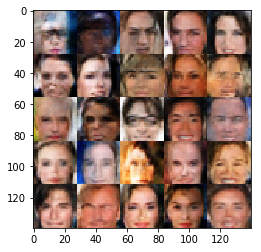

Epoch 2/5 Step 1510 Generator Loss: 0.6226... Discriminator Loss: 1.0973
Epoch 2/5 Step 1520 Generator Loss: 1.0354... Discriminator Loss: 1.2113
Epoch 2/5 Step 1530 Generator Loss: 0.9408... Discriminator Loss: 0.9610
Epoch 2/5 Step 1540 Generator Loss: 1.1416... Discriminator Loss: 1.1545
Epoch 2/5 Step 1550 Generator Loss: 1.2373... Discriminator Loss: 1.0529
Epoch 2/5 Step 1560 Generator Loss: 1.3377... Discriminator Loss: 0.9631
Epoch 2/5 Step 1570 Generator Loss: 1.5633... Discriminator Loss: 1.1279
Epoch 2/5 Step 1580 Generator Loss: 0.5290... Discriminator Loss: 1.2958
*********** Epoch 2 Ends *************
Epoch 3/5 Step 10 Generator Loss: 1.3799... Discriminator Loss: 1.3278
Epoch 3/5 Step 20 Generator Loss: 0.7508... Discriminator Loss: 1.0699
Epoch 3/5 Step 30 Generator Loss: 0.6934... Discriminator Loss: 1.0506
Epoch 3/5 Step 40 Generator Loss: 0.9196... Discriminator Loss: 1.0629
Epoch 3/5 Step 50 Generator Loss: 1.6414... Discriminator Loss: 1.3005
Epoch 3/5 Step 60 Gene

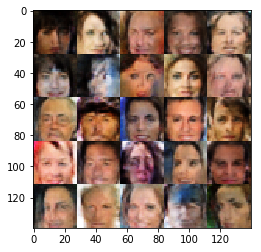

Epoch 3/5 Step 110 Generator Loss: 0.8027... Discriminator Loss: 1.1140
Epoch 3/5 Step 120 Generator Loss: 0.6675... Discriminator Loss: 1.1528
Epoch 3/5 Step 130 Generator Loss: 0.8619... Discriminator Loss: 1.2810
Epoch 3/5 Step 140 Generator Loss: 0.7673... Discriminator Loss: 1.0469
Epoch 3/5 Step 150 Generator Loss: 0.4396... Discriminator Loss: 1.3679
Epoch 3/5 Step 160 Generator Loss: 1.0824... Discriminator Loss: 1.0371
Epoch 3/5 Step 170 Generator Loss: 1.0296... Discriminator Loss: 1.2329
Epoch 3/5 Step 180 Generator Loss: 1.4513... Discriminator Loss: 0.9570
Epoch 3/5 Step 190 Generator Loss: 1.4102... Discriminator Loss: 1.6314
Epoch 3/5 Step 200 Generator Loss: 0.5618... Discriminator Loss: 1.2974


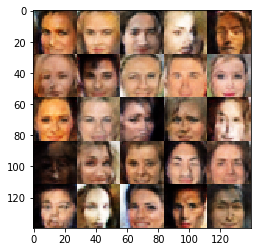

Epoch 3/5 Step 210 Generator Loss: 0.6491... Discriminator Loss: 1.0714
Epoch 3/5 Step 220 Generator Loss: 0.6826... Discriminator Loss: 1.0761
Epoch 3/5 Step 230 Generator Loss: 0.8442... Discriminator Loss: 1.0625
Epoch 3/5 Step 240 Generator Loss: 1.0512... Discriminator Loss: 1.0263
Epoch 3/5 Step 250 Generator Loss: 0.5774... Discriminator Loss: 1.8976
Epoch 3/5 Step 260 Generator Loss: 0.2478... Discriminator Loss: 1.8536
Epoch 3/5 Step 270 Generator Loss: 0.7035... Discriminator Loss: 1.1317
Epoch 3/5 Step 280 Generator Loss: 1.2932... Discriminator Loss: 1.0450
Epoch 3/5 Step 290 Generator Loss: 0.5509... Discriminator Loss: 1.1624
Epoch 3/5 Step 300 Generator Loss: 1.0233... Discriminator Loss: 1.0156


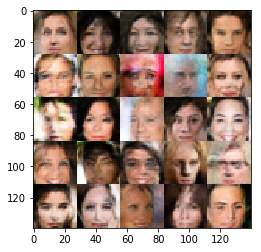

Epoch 3/5 Step 310 Generator Loss: 0.8333... Discriminator Loss: 1.0367
Epoch 3/5 Step 320 Generator Loss: 0.4209... Discriminator Loss: 1.4101
Epoch 3/5 Step 330 Generator Loss: 0.8684... Discriminator Loss: 1.0921
Epoch 3/5 Step 340 Generator Loss: 0.9857... Discriminator Loss: 1.1230
Epoch 3/5 Step 350 Generator Loss: 0.7281... Discriminator Loss: 1.1302
Epoch 3/5 Step 360 Generator Loss: 1.3760... Discriminator Loss: 1.2685
Epoch 3/5 Step 370 Generator Loss: 1.1952... Discriminator Loss: 1.1736
Epoch 3/5 Step 380 Generator Loss: 1.8779... Discriminator Loss: 1.4565
Epoch 3/5 Step 390 Generator Loss: 0.7535... Discriminator Loss: 1.0510
Epoch 3/5 Step 400 Generator Loss: 0.3435... Discriminator Loss: 1.9181


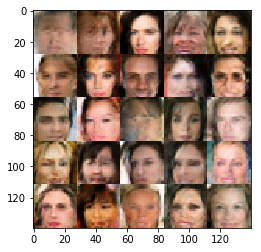

Epoch 3/5 Step 410 Generator Loss: 0.7854... Discriminator Loss: 1.1247
Epoch 3/5 Step 420 Generator Loss: 0.5531... Discriminator Loss: 1.2149
Epoch 3/5 Step 430 Generator Loss: 0.5160... Discriminator Loss: 1.2582
Epoch 3/5 Step 440 Generator Loss: 0.7884... Discriminator Loss: 1.0881
Epoch 3/5 Step 450 Generator Loss: 1.3923... Discriminator Loss: 1.1459
Epoch 3/5 Step 460 Generator Loss: 1.2762... Discriminator Loss: 1.0869
Epoch 3/5 Step 470 Generator Loss: 1.3551... Discriminator Loss: 1.1177
Epoch 3/5 Step 480 Generator Loss: 1.1499... Discriminator Loss: 1.0088
Epoch 3/5 Step 490 Generator Loss: 0.8579... Discriminator Loss: 0.9269
Epoch 3/5 Step 500 Generator Loss: 1.1327... Discriminator Loss: 1.0890


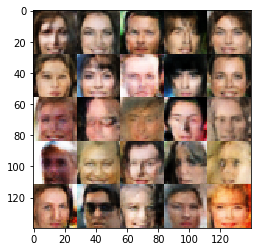

Epoch 3/5 Step 510 Generator Loss: 0.7996... Discriminator Loss: 1.0884
Epoch 3/5 Step 520 Generator Loss: 0.3150... Discriminator Loss: 1.5750
Epoch 3/5 Step 530 Generator Loss: 1.7186... Discriminator Loss: 1.3176
Epoch 3/5 Step 540 Generator Loss: 0.5708... Discriminator Loss: 1.2422
Epoch 3/5 Step 550 Generator Loss: 1.3885... Discriminator Loss: 1.3978
Epoch 3/5 Step 560 Generator Loss: 0.7188... Discriminator Loss: 1.1637
Epoch 3/5 Step 570 Generator Loss: 1.1603... Discriminator Loss: 1.0823
Epoch 3/5 Step 580 Generator Loss: 1.1415... Discriminator Loss: 1.1086
Epoch 3/5 Step 590 Generator Loss: 1.2478... Discriminator Loss: 1.0749
Epoch 3/5 Step 600 Generator Loss: 1.0019... Discriminator Loss: 1.0284


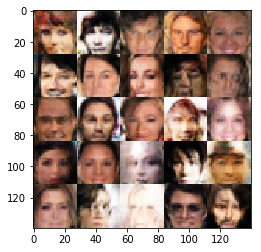

Epoch 3/5 Step 610 Generator Loss: 0.5756... Discriminator Loss: 1.2375
Epoch 3/5 Step 620 Generator Loss: 1.2933... Discriminator Loss: 1.2383
Epoch 3/5 Step 630 Generator Loss: 0.4505... Discriminator Loss: 1.2969
Epoch 3/5 Step 640 Generator Loss: 0.4309... Discriminator Loss: 1.3672
Epoch 3/5 Step 650 Generator Loss: 0.8786... Discriminator Loss: 1.0903
Epoch 3/5 Step 660 Generator Loss: 1.7541... Discriminator Loss: 1.2981
Epoch 3/5 Step 670 Generator Loss: 1.1361... Discriminator Loss: 1.2373
Epoch 3/5 Step 680 Generator Loss: 0.8428... Discriminator Loss: 1.0149
Epoch 3/5 Step 690 Generator Loss: 0.6793... Discriminator Loss: 1.0876
Epoch 3/5 Step 700 Generator Loss: 1.0146... Discriminator Loss: 1.0294


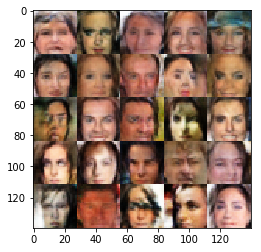

Epoch 3/5 Step 710 Generator Loss: 1.1073... Discriminator Loss: 0.8455
Epoch 3/5 Step 720 Generator Loss: 1.0781... Discriminator Loss: 1.1371
Epoch 3/5 Step 730 Generator Loss: 1.3797... Discriminator Loss: 0.9177
Epoch 3/5 Step 740 Generator Loss: 0.7786... Discriminator Loss: 1.0132
Epoch 3/5 Step 750 Generator Loss: 0.6440... Discriminator Loss: 1.1074
Epoch 3/5 Step 760 Generator Loss: 1.7272... Discriminator Loss: 1.3582
Epoch 3/5 Step 770 Generator Loss: 0.4578... Discriminator Loss: 1.3278
Epoch 3/5 Step 780 Generator Loss: 0.9823... Discriminator Loss: 0.8773
Epoch 3/5 Step 790 Generator Loss: 0.7350... Discriminator Loss: 0.9800
Epoch 3/5 Step 800 Generator Loss: 0.5100... Discriminator Loss: 1.2898


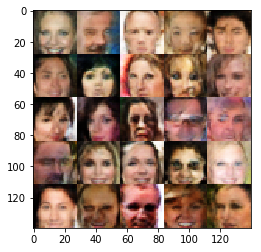

Epoch 3/5 Step 810 Generator Loss: 0.4325... Discriminator Loss: 1.3397
Epoch 3/5 Step 820 Generator Loss: 0.7002... Discriminator Loss: 1.0526
Epoch 3/5 Step 830 Generator Loss: 0.5468... Discriminator Loss: 1.2493
Epoch 3/5 Step 840 Generator Loss: 0.4537... Discriminator Loss: 1.4307
Epoch 3/5 Step 850 Generator Loss: 1.2556... Discriminator Loss: 1.0177
Epoch 3/5 Step 860 Generator Loss: 1.0175... Discriminator Loss: 1.0144
Epoch 3/5 Step 870 Generator Loss: 0.8125... Discriminator Loss: 1.0862
Epoch 3/5 Step 880 Generator Loss: 1.4233... Discriminator Loss: 1.4140
Epoch 3/5 Step 890 Generator Loss: 1.1654... Discriminator Loss: 1.0129
Epoch 3/5 Step 900 Generator Loss: 0.3976... Discriminator Loss: 1.4693


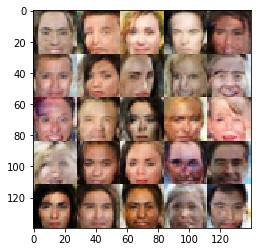

Epoch 3/5 Step 910 Generator Loss: 0.7842... Discriminator Loss: 1.0543
Epoch 3/5 Step 920 Generator Loss: 1.1475... Discriminator Loss: 1.0442
Epoch 3/5 Step 930 Generator Loss: 0.8145... Discriminator Loss: 0.9497
Epoch 3/5 Step 940 Generator Loss: 0.4370... Discriminator Loss: 1.4226
Epoch 3/5 Step 950 Generator Loss: 1.4071... Discriminator Loss: 0.9208
Epoch 3/5 Step 960 Generator Loss: 0.5361... Discriminator Loss: 1.1590
Epoch 3/5 Step 970 Generator Loss: 0.2564... Discriminator Loss: 1.8025
Epoch 3/5 Step 980 Generator Loss: 0.7512... Discriminator Loss: 1.1358
Epoch 3/5 Step 990 Generator Loss: 0.2816... Discriminator Loss: 1.6857
Epoch 3/5 Step 1000 Generator Loss: 0.6303... Discriminator Loss: 1.1004


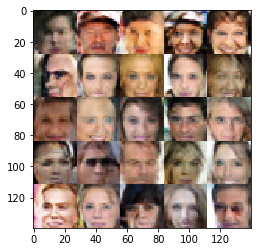

Epoch 3/5 Step 1010 Generator Loss: 1.7252... Discriminator Loss: 1.0829
Epoch 3/5 Step 1020 Generator Loss: 0.8618... Discriminator Loss: 0.9494
Epoch 3/5 Step 1030 Generator Loss: 0.5554... Discriminator Loss: 1.2482
Epoch 3/5 Step 1040 Generator Loss: 1.2713... Discriminator Loss: 1.0326
Epoch 3/5 Step 1050 Generator Loss: 0.7951... Discriminator Loss: 0.9942
Epoch 3/5 Step 1060 Generator Loss: 0.2525... Discriminator Loss: 1.7066
Epoch 3/5 Step 1070 Generator Loss: 0.9866... Discriminator Loss: 0.8944
Epoch 3/5 Step 1080 Generator Loss: 0.7959... Discriminator Loss: 1.0079
Epoch 3/5 Step 1090 Generator Loss: 0.7938... Discriminator Loss: 1.0541
Epoch 3/5 Step 1100 Generator Loss: 0.3280... Discriminator Loss: 1.5156


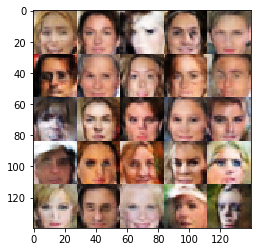

Epoch 3/5 Step 1110 Generator Loss: 0.7736... Discriminator Loss: 0.9613
Epoch 3/5 Step 1120 Generator Loss: 0.5343... Discriminator Loss: 1.1801
Epoch 3/5 Step 1130 Generator Loss: 0.7709... Discriminator Loss: 1.0328
Epoch 3/5 Step 1140 Generator Loss: 0.5878... Discriminator Loss: 1.1412
Epoch 3/5 Step 1150 Generator Loss: 0.2625... Discriminator Loss: 1.7064
Epoch 3/5 Step 1160 Generator Loss: 0.4340... Discriminator Loss: 1.3426
Epoch 3/5 Step 1170 Generator Loss: 0.4453... Discriminator Loss: 1.3359
Epoch 3/5 Step 1180 Generator Loss: 0.9542... Discriminator Loss: 0.9892
Epoch 3/5 Step 1190 Generator Loss: 1.2459... Discriminator Loss: 1.0387
Epoch 3/5 Step 1200 Generator Loss: 1.0103... Discriminator Loss: 0.9531


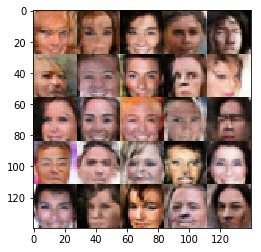

Epoch 3/5 Step 1210 Generator Loss: 1.1724... Discriminator Loss: 0.9865
Epoch 3/5 Step 1220 Generator Loss: 1.5307... Discriminator Loss: 0.9883
Epoch 3/5 Step 1230 Generator Loss: 0.4006... Discriminator Loss: 1.3883
Epoch 3/5 Step 1240 Generator Loss: 1.9351... Discriminator Loss: 1.4062
Epoch 3/5 Step 1250 Generator Loss: 0.8618... Discriminator Loss: 1.0480
Epoch 3/5 Step 1260 Generator Loss: 0.4552... Discriminator Loss: 1.2913
Epoch 3/5 Step 1270 Generator Loss: 1.6470... Discriminator Loss: 1.3341
Epoch 3/5 Step 1280 Generator Loss: 0.7886... Discriminator Loss: 1.0116
Epoch 3/5 Step 1290 Generator Loss: 0.4657... Discriminator Loss: 1.2831
Epoch 3/5 Step 1300 Generator Loss: 0.5227... Discriminator Loss: 1.2498


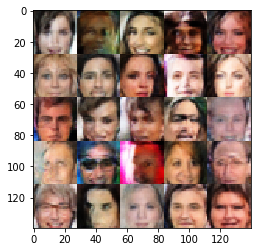

Epoch 3/5 Step 1310 Generator Loss: 1.2492... Discriminator Loss: 0.9539
Epoch 3/5 Step 1320 Generator Loss: 0.5577... Discriminator Loss: 1.1977
Epoch 3/5 Step 1330 Generator Loss: 0.2692... Discriminator Loss: 1.7544
Epoch 3/5 Step 1340 Generator Loss: 0.6504... Discriminator Loss: 1.1898
Epoch 3/5 Step 1350 Generator Loss: 1.0191... Discriminator Loss: 1.0156
Epoch 3/5 Step 1360 Generator Loss: 0.8098... Discriminator Loss: 0.9918
Epoch 3/5 Step 1370 Generator Loss: 0.4121... Discriminator Loss: 1.3328
Epoch 3/5 Step 1380 Generator Loss: 1.1990... Discriminator Loss: 0.8775
Epoch 3/5 Step 1390 Generator Loss: 1.0154... Discriminator Loss: 1.0233
Epoch 3/5 Step 1400 Generator Loss: 1.0120... Discriminator Loss: 0.9810


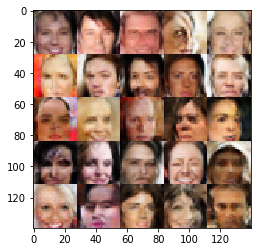

Epoch 3/5 Step 1410 Generator Loss: 0.4972... Discriminator Loss: 1.2500
Epoch 3/5 Step 1420 Generator Loss: 1.3040... Discriminator Loss: 1.0310
Epoch 3/5 Step 1430 Generator Loss: 0.4362... Discriminator Loss: 1.3337
Epoch 3/5 Step 1440 Generator Loss: 1.0961... Discriminator Loss: 0.7287
Epoch 3/5 Step 1450 Generator Loss: 0.5272... Discriminator Loss: 1.2350
Epoch 3/5 Step 1460 Generator Loss: 2.0800... Discriminator Loss: 1.3205
Epoch 3/5 Step 1470 Generator Loss: 0.2437... Discriminator Loss: 1.8993
Epoch 3/5 Step 1480 Generator Loss: 0.6436... Discriminator Loss: 1.1031
Epoch 3/5 Step 1490 Generator Loss: 0.7123... Discriminator Loss: 1.0033
Epoch 3/5 Step 1500 Generator Loss: 1.4219... Discriminator Loss: 1.0851


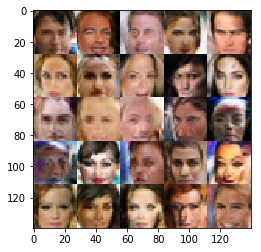

Epoch 3/5 Step 1510 Generator Loss: 0.6577... Discriminator Loss: 1.0440
Epoch 3/5 Step 1520 Generator Loss: 1.0567... Discriminator Loss: 0.9674
Epoch 3/5 Step 1530 Generator Loss: 1.1539... Discriminator Loss: 0.9600
Epoch 3/5 Step 1540 Generator Loss: 1.9463... Discriminator Loss: 0.7389
Epoch 3/5 Step 1550 Generator Loss: 1.2314... Discriminator Loss: 0.9558
Epoch 3/5 Step 1560 Generator Loss: 0.9878... Discriminator Loss: 0.8355
Epoch 3/5 Step 1570 Generator Loss: 4.4775... Discriminator Loss: 1.6541
Epoch 3/5 Step 1580 Generator Loss: 0.4577... Discriminator Loss: 1.3376
*********** Epoch 3 Ends *************
Epoch 4/5 Step 10 Generator Loss: 1.0886... Discriminator Loss: 0.8393
Epoch 4/5 Step 20 Generator Loss: 1.2944... Discriminator Loss: 1.0643
Epoch 4/5 Step 30 Generator Loss: 0.3178... Discriminator Loss: 1.6188
Epoch 4/5 Step 40 Generator Loss: 0.3533... Discriminator Loss: 1.4938
Epoch 4/5 Step 50 Generator Loss: 3.1031... Discriminator Loss: 2.2176
Epoch 4/5 Step 60 Gene

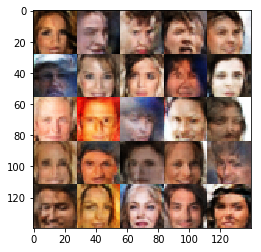

Epoch 4/5 Step 110 Generator Loss: 0.6124... Discriminator Loss: 1.1471
Epoch 4/5 Step 120 Generator Loss: 0.7399... Discriminator Loss: 1.0136
Epoch 4/5 Step 130 Generator Loss: 0.4254... Discriminator Loss: 1.3477
Epoch 4/5 Step 140 Generator Loss: 0.9972... Discriminator Loss: 1.0926
Epoch 4/5 Step 150 Generator Loss: 0.7853... Discriminator Loss: 1.1006
Epoch 4/5 Step 160 Generator Loss: 1.2958... Discriminator Loss: 0.8291
Epoch 4/5 Step 170 Generator Loss: 1.6119... Discriminator Loss: 0.9976
Epoch 4/5 Step 180 Generator Loss: 0.9824... Discriminator Loss: 0.9854
Epoch 4/5 Step 190 Generator Loss: 1.6782... Discriminator Loss: 1.0522
Epoch 4/5 Step 200 Generator Loss: 0.4215... Discriminator Loss: 1.3614


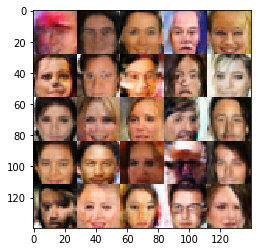

Epoch 4/5 Step 210 Generator Loss: 1.0579... Discriminator Loss: 1.0226
Epoch 4/5 Step 220 Generator Loss: 0.9955... Discriminator Loss: 0.9444
Epoch 4/5 Step 230 Generator Loss: 0.3648... Discriminator Loss: 1.5143
Epoch 4/5 Step 240 Generator Loss: 0.8597... Discriminator Loss: 0.8643
Epoch 4/5 Step 250 Generator Loss: 1.4175... Discriminator Loss: 1.1145
Epoch 4/5 Step 260 Generator Loss: 0.3015... Discriminator Loss: 1.6587
Epoch 4/5 Step 270 Generator Loss: 0.7682... Discriminator Loss: 0.9605
Epoch 4/5 Step 280 Generator Loss: 1.0663... Discriminator Loss: 0.9169
Epoch 4/5 Step 290 Generator Loss: 0.6585... Discriminator Loss: 1.1449
Epoch 4/5 Step 300 Generator Loss: 2.4341... Discriminator Loss: 1.3457


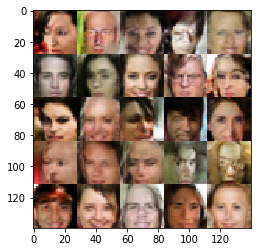

Epoch 4/5 Step 310 Generator Loss: 0.8512... Discriminator Loss: 0.9603
Epoch 4/5 Step 320 Generator Loss: 0.8598... Discriminator Loss: 0.8437
Epoch 4/5 Step 330 Generator Loss: 0.6928... Discriminator Loss: 0.9324
Epoch 4/5 Step 340 Generator Loss: 0.6238... Discriminator Loss: 1.0899
Epoch 4/5 Step 350 Generator Loss: 1.5273... Discriminator Loss: 0.9337
Epoch 4/5 Step 360 Generator Loss: 1.1794... Discriminator Loss: 0.8765
Epoch 4/5 Step 370 Generator Loss: 1.5170... Discriminator Loss: 0.8362
Epoch 4/5 Step 380 Generator Loss: 0.8916... Discriminator Loss: 0.9414
Epoch 4/5 Step 390 Generator Loss: 0.4952... Discriminator Loss: 1.2947
Epoch 4/5 Step 400 Generator Loss: 0.8936... Discriminator Loss: 0.9137


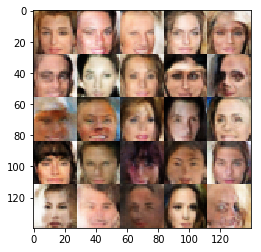

Epoch 4/5 Step 410 Generator Loss: 0.9538... Discriminator Loss: 0.9303
Epoch 4/5 Step 420 Generator Loss: 0.7529... Discriminator Loss: 0.9980
Epoch 4/5 Step 430 Generator Loss: 0.4190... Discriminator Loss: 1.3195
Epoch 4/5 Step 440 Generator Loss: 1.3126... Discriminator Loss: 0.8430
Epoch 4/5 Step 450 Generator Loss: 0.9752... Discriminator Loss: 0.7949
Epoch 4/5 Step 460 Generator Loss: 2.0120... Discriminator Loss: 1.0849
Epoch 4/5 Step 470 Generator Loss: 1.0723... Discriminator Loss: 0.8882
Epoch 4/5 Step 480 Generator Loss: 1.0973... Discriminator Loss: 0.7253
Epoch 4/5 Step 490 Generator Loss: 0.4344... Discriminator Loss: 1.3354
Epoch 4/5 Step 500 Generator Loss: 0.8138... Discriminator Loss: 0.8650


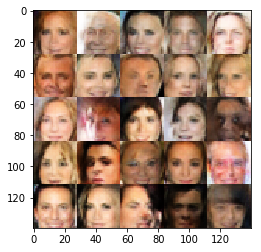

Epoch 4/5 Step 510 Generator Loss: 1.1914... Discriminator Loss: 0.7054
Epoch 4/5 Step 520 Generator Loss: 1.1981... Discriminator Loss: 1.0310
Epoch 4/5 Step 530 Generator Loss: 0.2211... Discriminator Loss: 1.9145
Epoch 4/5 Step 540 Generator Loss: 1.2764... Discriminator Loss: 0.8929
Epoch 4/5 Step 550 Generator Loss: 1.4305... Discriminator Loss: 0.5051
Epoch 4/5 Step 560 Generator Loss: 1.1563... Discriminator Loss: 0.9488
Epoch 4/5 Step 570 Generator Loss: 0.6570... Discriminator Loss: 0.9461
Epoch 4/5 Step 580 Generator Loss: 1.0676... Discriminator Loss: 1.0428
Epoch 4/5 Step 590 Generator Loss: 1.0637... Discriminator Loss: 0.8752
Epoch 4/5 Step 600 Generator Loss: 1.6912... Discriminator Loss: 1.0255


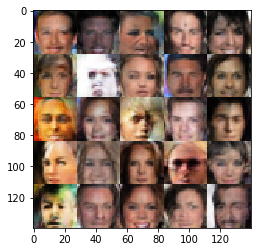

Epoch 4/5 Step 610 Generator Loss: 1.4407... Discriminator Loss: 1.1173
Epoch 4/5 Step 620 Generator Loss: 0.5082... Discriminator Loss: 1.1510
Epoch 4/5 Step 630 Generator Loss: 1.1397... Discriminator Loss: 0.8160
Epoch 4/5 Step 640 Generator Loss: 0.6674... Discriminator Loss: 1.0483
Epoch 4/5 Step 650 Generator Loss: 1.0363... Discriminator Loss: 0.9800
Epoch 4/5 Step 660 Generator Loss: 1.1159... Discriminator Loss: 0.6687
Epoch 4/5 Step 670 Generator Loss: 1.2057... Discriminator Loss: 0.6428
Epoch 4/5 Step 680 Generator Loss: 0.7291... Discriminator Loss: 0.8954
Epoch 4/5 Step 690 Generator Loss: 1.3670... Discriminator Loss: 0.5315
Epoch 4/5 Step 700 Generator Loss: 2.2422... Discriminator Loss: 1.2212


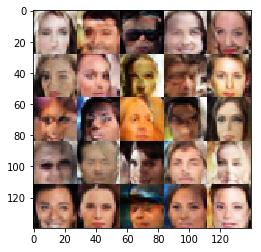

Epoch 4/5 Step 710 Generator Loss: 0.7913... Discriminator Loss: 0.9247
Epoch 4/5 Step 720 Generator Loss: 0.9584... Discriminator Loss: 0.8372
Epoch 4/5 Step 730 Generator Loss: 0.7804... Discriminator Loss: 0.9254
Epoch 4/5 Step 740 Generator Loss: 0.3179... Discriminator Loss: 1.5517
Epoch 4/5 Step 750 Generator Loss: 0.3618... Discriminator Loss: 1.4347
Epoch 4/5 Step 760 Generator Loss: 1.0054... Discriminator Loss: 0.8687
Epoch 4/5 Step 770 Generator Loss: 1.3938... Discriminator Loss: 1.0030
Epoch 4/5 Step 780 Generator Loss: 1.9567... Discriminator Loss: 0.9001
Epoch 4/5 Step 790 Generator Loss: 0.6196... Discriminator Loss: 1.1140
Epoch 4/5 Step 800 Generator Loss: 1.3767... Discriminator Loss: 0.7921


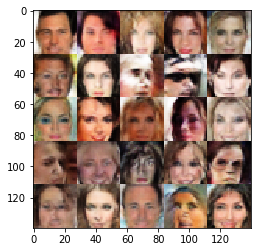

Epoch 4/5 Step 810 Generator Loss: 0.5051... Discriminator Loss: 1.2473
Epoch 4/5 Step 820 Generator Loss: 1.2848... Discriminator Loss: 0.7323
Epoch 4/5 Step 830 Generator Loss: 1.3822... Discriminator Loss: 0.5820
Epoch 4/5 Step 840 Generator Loss: 0.5510... Discriminator Loss: 1.1102
Epoch 4/5 Step 850 Generator Loss: 1.2641... Discriminator Loss: 0.7640
Epoch 4/5 Step 860 Generator Loss: 0.8209... Discriminator Loss: 0.9567
Epoch 4/5 Step 870 Generator Loss: 1.0236... Discriminator Loss: 0.8589
Epoch 4/5 Step 880 Generator Loss: 0.3871... Discriminator Loss: 1.4275
Epoch 4/5 Step 890 Generator Loss: 1.5546... Discriminator Loss: 0.4984
Epoch 4/5 Step 900 Generator Loss: 0.4070... Discriminator Loss: 1.3165


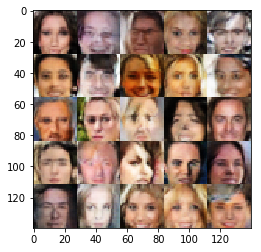

Epoch 4/5 Step 910 Generator Loss: 0.5771... Discriminator Loss: 1.0728
Epoch 4/5 Step 920 Generator Loss: 1.6129... Discriminator Loss: 0.6712
Epoch 4/5 Step 930 Generator Loss: 0.9666... Discriminator Loss: 0.7350
Epoch 4/5 Step 940 Generator Loss: 2.6881... Discriminator Loss: 1.0981
Epoch 4/5 Step 950 Generator Loss: 1.1869... Discriminator Loss: 0.5985
Epoch 4/5 Step 960 Generator Loss: 1.7773... Discriminator Loss: 0.7399
Epoch 4/5 Step 970 Generator Loss: 0.5077... Discriminator Loss: 1.2162
Epoch 4/5 Step 980 Generator Loss: 0.5876... Discriminator Loss: 1.1079
Epoch 4/5 Step 990 Generator Loss: 0.1456... Discriminator Loss: 2.5224
Epoch 4/5 Step 1000 Generator Loss: 0.6275... Discriminator Loss: 1.0656


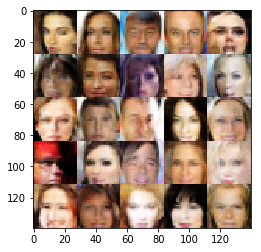

Epoch 4/5 Step 1010 Generator Loss: 0.7883... Discriminator Loss: 0.9394
Epoch 4/5 Step 1020 Generator Loss: 1.0328... Discriminator Loss: 0.7388
Epoch 4/5 Step 1030 Generator Loss: 0.7769... Discriminator Loss: 0.9381
Epoch 4/5 Step 1040 Generator Loss: 1.1420... Discriminator Loss: 0.8273
Epoch 4/5 Step 1050 Generator Loss: 0.9175... Discriminator Loss: 0.7007
Epoch 4/5 Step 1060 Generator Loss: 0.5909... Discriminator Loss: 1.1320
Epoch 4/5 Step 1070 Generator Loss: 1.7694... Discriminator Loss: 0.7275
Epoch 4/5 Step 1080 Generator Loss: 1.3973... Discriminator Loss: 0.5627
Epoch 4/5 Step 1090 Generator Loss: 1.5695... Discriminator Loss: 0.6745
Epoch 4/5 Step 1100 Generator Loss: 0.7977... Discriminator Loss: 0.9731


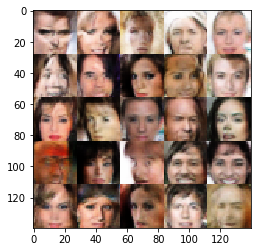

Epoch 4/5 Step 1110 Generator Loss: 1.0595... Discriminator Loss: 0.6907
Epoch 4/5 Step 1120 Generator Loss: 1.2238... Discriminator Loss: 0.7131
Epoch 4/5 Step 1130 Generator Loss: 1.0771... Discriminator Loss: 0.6733
Epoch 4/5 Step 1140 Generator Loss: 2.7559... Discriminator Loss: 1.6889
Epoch 4/5 Step 1150 Generator Loss: 0.6359... Discriminator Loss: 1.1374
Epoch 4/5 Step 1160 Generator Loss: 1.7072... Discriminator Loss: 0.5266
Epoch 4/5 Step 1170 Generator Loss: 0.2335... Discriminator Loss: 1.9839
Epoch 4/5 Step 1180 Generator Loss: 1.9435... Discriminator Loss: 0.8191
Epoch 4/5 Step 1190 Generator Loss: 0.3340... Discriminator Loss: 1.5599
Epoch 4/5 Step 1200 Generator Loss: 1.1548... Discriminator Loss: 0.7775


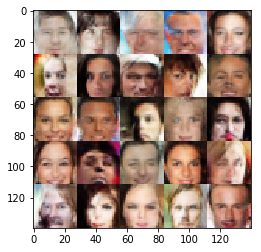

Epoch 4/5 Step 1210 Generator Loss: 1.7073... Discriminator Loss: 0.5751
Epoch 4/5 Step 1220 Generator Loss: 1.1077... Discriminator Loss: 0.6701
Epoch 4/5 Step 1230 Generator Loss: 0.8484... Discriminator Loss: 0.8228
Epoch 4/5 Step 1240 Generator Loss: 2.1651... Discriminator Loss: 0.9544
Epoch 4/5 Step 1250 Generator Loss: 0.8935... Discriminator Loss: 0.9138
Epoch 4/5 Step 1260 Generator Loss: 1.1352... Discriminator Loss: 0.6504
Epoch 4/5 Step 1270 Generator Loss: 0.2874... Discriminator Loss: 1.6877
Epoch 4/5 Step 1280 Generator Loss: 0.7473... Discriminator Loss: 0.8596
Epoch 4/5 Step 1290 Generator Loss: 2.6855... Discriminator Loss: 1.3151
Epoch 4/5 Step 1300 Generator Loss: 0.8802... Discriminator Loss: 0.8300


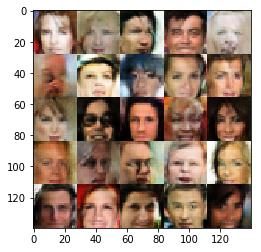

Epoch 4/5 Step 1310 Generator Loss: 1.2851... Discriminator Loss: 0.7934
Epoch 4/5 Step 1320 Generator Loss: 0.7996... Discriminator Loss: 0.8649
Epoch 4/5 Step 1330 Generator Loss: 1.9923... Discriminator Loss: 0.9592
Epoch 4/5 Step 1340 Generator Loss: 0.9355... Discriminator Loss: 0.7811
Epoch 4/5 Step 1350 Generator Loss: 0.9820... Discriminator Loss: 0.6818
Epoch 4/5 Step 1360 Generator Loss: 0.4152... Discriminator Loss: 1.3516
Epoch 4/5 Step 1370 Generator Loss: 2.2403... Discriminator Loss: 0.8513
Epoch 4/5 Step 1380 Generator Loss: 1.0309... Discriminator Loss: 0.7813
Epoch 4/5 Step 1390 Generator Loss: 0.4916... Discriminator Loss: 1.2337
Epoch 4/5 Step 1400 Generator Loss: 1.3358... Discriminator Loss: 0.5933


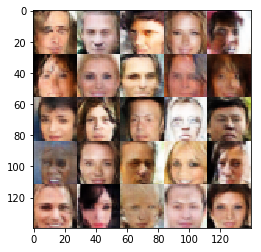

Epoch 4/5 Step 1410 Generator Loss: 1.0652... Discriminator Loss: 0.6312
Epoch 4/5 Step 1420 Generator Loss: 1.4195... Discriminator Loss: 0.4550
Epoch 4/5 Step 1430 Generator Loss: 0.1775... Discriminator Loss: 2.2181
Epoch 4/5 Step 1440 Generator Loss: 1.8098... Discriminator Loss: 0.5172
Epoch 4/5 Step 1450 Generator Loss: 0.5123... Discriminator Loss: 1.2684
Epoch 4/5 Step 1460 Generator Loss: 0.5085... Discriminator Loss: 1.3008
Epoch 4/5 Step 1470 Generator Loss: 1.3155... Discriminator Loss: 0.6708
Epoch 4/5 Step 1480 Generator Loss: 0.6180... Discriminator Loss: 1.0032
Epoch 4/5 Step 1490 Generator Loss: 0.8654... Discriminator Loss: 0.7740
Epoch 4/5 Step 1500 Generator Loss: 0.9349... Discriminator Loss: 0.7666


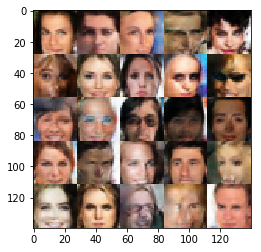

Epoch 4/5 Step 1510 Generator Loss: 1.4215... Discriminator Loss: 0.5971
Epoch 4/5 Step 1520 Generator Loss: 1.0836... Discriminator Loss: 0.6263
Epoch 4/5 Step 1530 Generator Loss: 1.2155... Discriminator Loss: 0.5558
Epoch 4/5 Step 1540 Generator Loss: 1.9162... Discriminator Loss: 0.4202
Epoch 4/5 Step 1550 Generator Loss: 0.8861... Discriminator Loss: 0.7295
Epoch 4/5 Step 1560 Generator Loss: 1.9420... Discriminator Loss: 0.8954
Epoch 4/5 Step 1570 Generator Loss: 0.9354... Discriminator Loss: 0.7086
Epoch 4/5 Step 1580 Generator Loss: 0.3347... Discriminator Loss: 1.6265
*********** Epoch 4 Ends *************
Epoch 5/5 Step 10 Generator Loss: 1.7545... Discriminator Loss: 0.8927
Epoch 5/5 Step 20 Generator Loss: 1.6751... Discriminator Loss: 0.5605
Epoch 5/5 Step 30 Generator Loss: 1.4839... Discriminator Loss: 0.4641
Epoch 5/5 Step 40 Generator Loss: 1.2113... Discriminator Loss: 0.7478
Epoch 5/5 Step 50 Generator Loss: 0.2796... Discriminator Loss: 1.7948
Epoch 5/5 Step 60 Gene

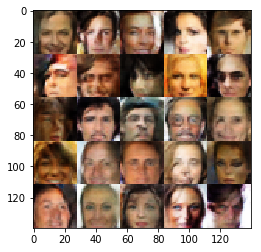

Epoch 5/5 Step 110 Generator Loss: 0.4166... Discriminator Loss: 1.5128
Epoch 5/5 Step 120 Generator Loss: 0.6480... Discriminator Loss: 1.0559
Epoch 5/5 Step 130 Generator Loss: 3.2690... Discriminator Loss: 0.5259
Epoch 5/5 Step 140 Generator Loss: 1.0824... Discriminator Loss: 0.6479
Epoch 5/5 Step 150 Generator Loss: 4.3184... Discriminator Loss: 0.4092
Epoch 5/5 Step 160 Generator Loss: 0.1557... Discriminator Loss: 2.4008
Epoch 5/5 Step 170 Generator Loss: 1.5157... Discriminator Loss: 0.6790
Epoch 5/5 Step 180 Generator Loss: 0.8330... Discriminator Loss: 1.0180
Epoch 5/5 Step 190 Generator Loss: 1.7761... Discriminator Loss: 0.4103
Epoch 5/5 Step 200 Generator Loss: 1.8891... Discriminator Loss: 0.4960


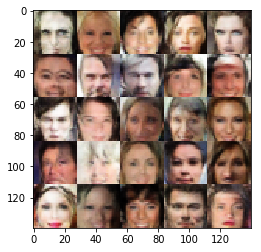

Epoch 5/5 Step 210 Generator Loss: 1.1826... Discriminator Loss: 0.6520
Epoch 5/5 Step 220 Generator Loss: 1.1913... Discriminator Loss: 0.6383
Epoch 5/5 Step 230 Generator Loss: 0.4860... Discriminator Loss: 1.2953
Epoch 5/5 Step 240 Generator Loss: 0.3362... Discriminator Loss: 1.5788
Epoch 5/5 Step 250 Generator Loss: 1.1547... Discriminator Loss: 1.0039
Epoch 5/5 Step 260 Generator Loss: 0.3243... Discriminator Loss: 1.6351
Epoch 5/5 Step 270 Generator Loss: 1.9876... Discriminator Loss: 0.3948
Epoch 5/5 Step 280 Generator Loss: 0.7781... Discriminator Loss: 0.8362
Epoch 5/5 Step 290 Generator Loss: 1.5915... Discriminator Loss: 0.4647
Epoch 5/5 Step 300 Generator Loss: 0.9664... Discriminator Loss: 0.7941


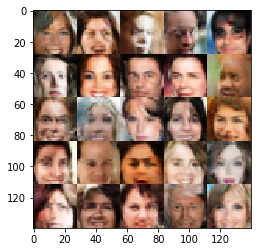

Epoch 5/5 Step 310 Generator Loss: 2.4018... Discriminator Loss: 1.0676
Epoch 5/5 Step 320 Generator Loss: 0.9967... Discriminator Loss: 0.7144
Epoch 5/5 Step 330 Generator Loss: 0.6478... Discriminator Loss: 1.0315
Epoch 5/5 Step 340 Generator Loss: 1.0776... Discriminator Loss: 0.7013
Epoch 5/5 Step 350 Generator Loss: 2.9496... Discriminator Loss: 0.7415
Epoch 5/5 Step 360 Generator Loss: 1.9759... Discriminator Loss: 0.6317
Epoch 5/5 Step 370 Generator Loss: 0.3363... Discriminator Loss: 1.6687
Epoch 5/5 Step 380 Generator Loss: 1.6005... Discriminator Loss: 0.6434
Epoch 5/5 Step 390 Generator Loss: 0.3533... Discriminator Loss: 1.6504
Epoch 5/5 Step 400 Generator Loss: 0.8369... Discriminator Loss: 0.8438


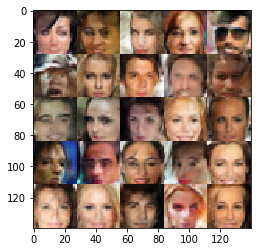

Epoch 5/5 Step 410 Generator Loss: 0.8085... Discriminator Loss: 0.8193
Epoch 5/5 Step 420 Generator Loss: 0.9673... Discriminator Loss: 0.7807
Epoch 5/5 Step 430 Generator Loss: 0.3350... Discriminator Loss: 2.0748
Epoch 5/5 Step 440 Generator Loss: 2.6925... Discriminator Loss: 1.0870
Epoch 5/5 Step 450 Generator Loss: 0.9854... Discriminator Loss: 0.7730
Epoch 5/5 Step 460 Generator Loss: 1.1684... Discriminator Loss: 0.7407
Epoch 5/5 Step 470 Generator Loss: 0.8133... Discriminator Loss: 0.8721
Epoch 5/5 Step 480 Generator Loss: 1.6831... Discriminator Loss: 0.6610
Epoch 5/5 Step 490 Generator Loss: 0.2912... Discriminator Loss: 1.7342
Epoch 5/5 Step 500 Generator Loss: 1.0531... Discriminator Loss: 0.6524


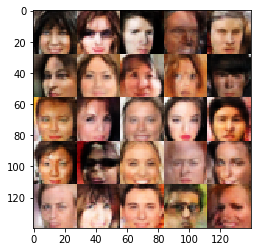

Epoch 5/5 Step 510 Generator Loss: 1.8413... Discriminator Loss: 0.6812
Epoch 5/5 Step 520 Generator Loss: 0.8749... Discriminator Loss: 0.7798
Epoch 5/5 Step 530 Generator Loss: 0.2144... Discriminator Loss: 1.9623
Epoch 5/5 Step 540 Generator Loss: 1.5374... Discriminator Loss: 0.4960
Epoch 5/5 Step 550 Generator Loss: 2.4643... Discriminator Loss: 0.4975
Epoch 5/5 Step 560 Generator Loss: 1.5944... Discriminator Loss: 0.5180
Epoch 5/5 Step 570 Generator Loss: 1.1841... Discriminator Loss: 0.5942
Epoch 5/5 Step 580 Generator Loss: 1.1804... Discriminator Loss: 0.5364
Epoch 5/5 Step 590 Generator Loss: 1.0973... Discriminator Loss: 0.6483
Epoch 5/5 Step 600 Generator Loss: 0.7768... Discriminator Loss: 0.9041


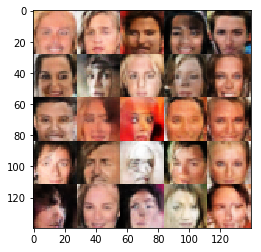

Epoch 5/5 Step 610 Generator Loss: 1.3290... Discriminator Loss: 0.8961
Epoch 5/5 Step 620 Generator Loss: 1.4581... Discriminator Loss: 0.4104
Epoch 5/5 Step 630 Generator Loss: 2.6588... Discriminator Loss: 0.2248
Epoch 5/5 Step 640 Generator Loss: 2.0763... Discriminator Loss: 0.6343
Epoch 5/5 Step 650 Generator Loss: 0.1900... Discriminator Loss: 2.2408
Epoch 5/5 Step 660 Generator Loss: 2.4404... Discriminator Loss: 0.7860
Epoch 5/5 Step 670 Generator Loss: 1.4979... Discriminator Loss: 0.7167
Epoch 5/5 Step 680 Generator Loss: 1.6157... Discriminator Loss: 0.4949
Epoch 5/5 Step 690 Generator Loss: 3.3639... Discriminator Loss: 0.9288
Epoch 5/5 Step 700 Generator Loss: 2.5129... Discriminator Loss: 0.4265


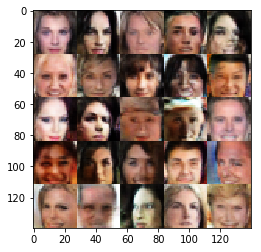

Epoch 5/5 Step 710 Generator Loss: 1.6779... Discriminator Loss: 0.4701
Epoch 5/5 Step 720 Generator Loss: 1.9852... Discriminator Loss: 0.6202
Epoch 5/5 Step 730 Generator Loss: 1.5069... Discriminator Loss: 0.4720
Epoch 5/5 Step 740 Generator Loss: 1.5584... Discriminator Loss: 0.4223
Epoch 5/5 Step 750 Generator Loss: 0.4363... Discriminator Loss: 1.3244
Epoch 5/5 Step 760 Generator Loss: 1.6680... Discriminator Loss: 0.4531
Epoch 5/5 Step 770 Generator Loss: 0.8855... Discriminator Loss: 0.7832
Epoch 5/5 Step 780 Generator Loss: 0.5715... Discriminator Loss: 1.2394
Epoch 5/5 Step 790 Generator Loss: 0.7941... Discriminator Loss: 0.9723
Epoch 5/5 Step 800 Generator Loss: 0.7498... Discriminator Loss: 0.9736


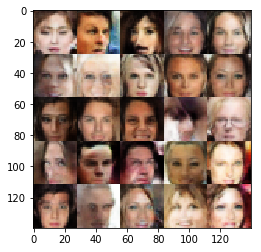

Epoch 5/5 Step 810 Generator Loss: 1.1076... Discriminator Loss: 0.7297
Epoch 5/5 Step 820 Generator Loss: 1.0964... Discriminator Loss: 0.7771
Epoch 5/5 Step 830 Generator Loss: 1.2220... Discriminator Loss: 0.5661
Epoch 5/5 Step 840 Generator Loss: 1.2680... Discriminator Loss: 0.5774
Epoch 5/5 Step 850 Generator Loss: 1.7637... Discriminator Loss: 0.3663
Epoch 5/5 Step 860 Generator Loss: 1.4415... Discriminator Loss: 0.4865
Epoch 5/5 Step 870 Generator Loss: 0.2385... Discriminator Loss: 2.2102
Epoch 5/5 Step 880 Generator Loss: 0.6215... Discriminator Loss: 1.6793
Epoch 5/5 Step 890 Generator Loss: 1.9622... Discriminator Loss: 0.6240
Epoch 5/5 Step 900 Generator Loss: 0.9100... Discriminator Loss: 0.9330


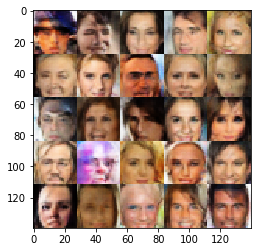

Epoch 5/5 Step 910 Generator Loss: 1.3600... Discriminator Loss: 0.6025
Epoch 5/5 Step 920 Generator Loss: 1.9408... Discriminator Loss: 0.3701
Epoch 5/5 Step 930 Generator Loss: 1.0324... Discriminator Loss: 0.6735
Epoch 5/5 Step 940 Generator Loss: 1.5852... Discriminator Loss: 0.4743
Epoch 5/5 Step 950 Generator Loss: 1.6117... Discriminator Loss: 0.5119
Epoch 5/5 Step 960 Generator Loss: 2.7314... Discriminator Loss: 1.0619
Epoch 5/5 Step 970 Generator Loss: 1.1484... Discriminator Loss: 0.6957
Epoch 5/5 Step 980 Generator Loss: 0.8004... Discriminator Loss: 0.8787
Epoch 5/5 Step 990 Generator Loss: 0.5549... Discriminator Loss: 1.1212
Epoch 5/5 Step 1000 Generator Loss: 1.2274... Discriminator Loss: 0.5885


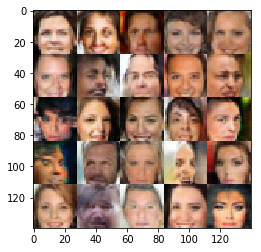

Epoch 5/5 Step 1010 Generator Loss: 2.4423... Discriminator Loss: 0.3041
Epoch 5/5 Step 1020 Generator Loss: 1.3012... Discriminator Loss: 0.5210
Epoch 5/5 Step 1030 Generator Loss: 0.5195... Discriminator Loss: 1.1682
Epoch 5/5 Step 1040 Generator Loss: 0.9636... Discriminator Loss: 0.7159
Epoch 5/5 Step 1050 Generator Loss: 0.9947... Discriminator Loss: 0.6561
Epoch 5/5 Step 1060 Generator Loss: 0.4799... Discriminator Loss: 1.3392
Epoch 5/5 Step 1070 Generator Loss: 0.8411... Discriminator Loss: 1.5125
Epoch 5/5 Step 1080 Generator Loss: 1.3794... Discriminator Loss: 0.6170
Epoch 5/5 Step 1090 Generator Loss: 2.8985... Discriminator Loss: 0.6462
Epoch 5/5 Step 1100 Generator Loss: 0.8812... Discriminator Loss: 0.8352


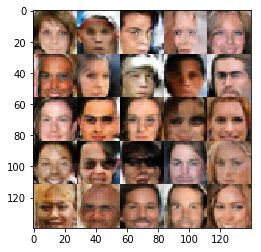

Epoch 5/5 Step 1110 Generator Loss: 1.2900... Discriminator Loss: 0.5306
Epoch 5/5 Step 1120 Generator Loss: 0.5041... Discriminator Loss: 1.1512
Epoch 5/5 Step 1130 Generator Loss: 0.7425... Discriminator Loss: 0.9035
Epoch 5/5 Step 1140 Generator Loss: 1.6818... Discriminator Loss: 0.5918
Epoch 5/5 Step 1150 Generator Loss: 2.0957... Discriminator Loss: 0.6732
Epoch 5/5 Step 1160 Generator Loss: 0.7918... Discriminator Loss: 0.8720
Epoch 5/5 Step 1170 Generator Loss: 1.7160... Discriminator Loss: 0.5247
Epoch 5/5 Step 1180 Generator Loss: 0.9236... Discriminator Loss: 0.7458
Epoch 5/5 Step 1190 Generator Loss: 0.9356... Discriminator Loss: 0.7546
Epoch 5/5 Step 1200 Generator Loss: 1.0036... Discriminator Loss: 0.7025


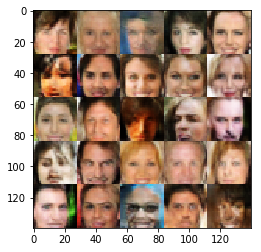

Epoch 5/5 Step 1210 Generator Loss: 2.4737... Discriminator Loss: 0.6258
Epoch 5/5 Step 1220 Generator Loss: 1.0546... Discriminator Loss: 0.7568
Epoch 5/5 Step 1230 Generator Loss: 0.9555... Discriminator Loss: 0.7464
Epoch 5/5 Step 1240 Generator Loss: 2.5647... Discriminator Loss: 0.7534
Epoch 5/5 Step 1250 Generator Loss: 1.4845... Discriminator Loss: 0.4985
Epoch 5/5 Step 1260 Generator Loss: 1.3710... Discriminator Loss: 0.5642
Epoch 5/5 Step 1270 Generator Loss: 1.2166... Discriminator Loss: 0.5841
Epoch 5/5 Step 1280 Generator Loss: 1.5467... Discriminator Loss: 0.4610
Epoch 5/5 Step 1290 Generator Loss: 0.3891... Discriminator Loss: 1.7819
Epoch 5/5 Step 1300 Generator Loss: 0.7128... Discriminator Loss: 0.9738


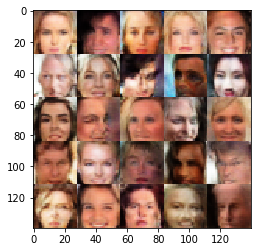

Epoch 5/5 Step 1310 Generator Loss: 0.7828... Discriminator Loss: 0.9375
Epoch 5/5 Step 1320 Generator Loss: 1.3213... Discriminator Loss: 0.5542
Epoch 5/5 Step 1330 Generator Loss: 1.3095... Discriminator Loss: 0.5242
Epoch 5/5 Step 1340 Generator Loss: 0.3330... Discriminator Loss: 1.6554
Epoch 5/5 Step 1350 Generator Loss: 0.5013... Discriminator Loss: 1.2999
Epoch 5/5 Step 1360 Generator Loss: 0.3939... Discriminator Loss: 1.6425
Epoch 5/5 Step 1370 Generator Loss: 1.5363... Discriminator Loss: 0.5787
Epoch 5/5 Step 1380 Generator Loss: 1.8474... Discriminator Loss: 0.4005
Epoch 5/5 Step 1390 Generator Loss: 0.4956... Discriminator Loss: 1.2410
Epoch 5/5 Step 1400 Generator Loss: 3.4413... Discriminator Loss: 0.9790


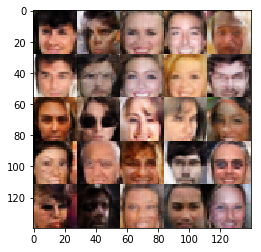

Epoch 5/5 Step 1410 Generator Loss: 0.6536... Discriminator Loss: 1.0692
Epoch 5/5 Step 1420 Generator Loss: 1.3624... Discriminator Loss: 0.5113
Epoch 5/5 Step 1430 Generator Loss: 1.6713... Discriminator Loss: 0.4474
Epoch 5/5 Step 1440 Generator Loss: 1.1786... Discriminator Loss: 0.6265
Epoch 5/5 Step 1450 Generator Loss: 1.1722... Discriminator Loss: 0.6218
Epoch 5/5 Step 1460 Generator Loss: 0.5640... Discriminator Loss: 1.1011
Epoch 5/5 Step 1470 Generator Loss: 0.7256... Discriminator Loss: 1.0514
Epoch 5/5 Step 1480 Generator Loss: 0.8761... Discriminator Loss: 0.8071
Epoch 5/5 Step 1490 Generator Loss: 2.8507... Discriminator Loss: 0.4302
Epoch 5/5 Step 1500 Generator Loss: 1.1194... Discriminator Loss: 0.6256


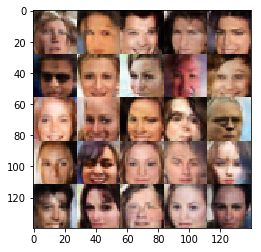

Epoch 5/5 Step 1510 Generator Loss: 0.7324... Discriminator Loss: 0.9566
Epoch 5/5 Step 1520 Generator Loss: 0.9292... Discriminator Loss: 0.8187
Epoch 5/5 Step 1530 Generator Loss: 1.1544... Discriminator Loss: 0.5797
Epoch 5/5 Step 1540 Generator Loss: 1.9755... Discriminator Loss: 0.3430
Epoch 5/5 Step 1550 Generator Loss: 1.2004... Discriminator Loss: 0.6218
Epoch 5/5 Step 1560 Generator Loss: 2.9921... Discriminator Loss: 1.2321
Epoch 5/5 Step 1570 Generator Loss: 3.0363... Discriminator Loss: 0.9849
Epoch 5/5 Step 1580 Generator Loss: 1.1035... Discriminator Loss: 0.7274
*********** Epoch 5 Ends *************


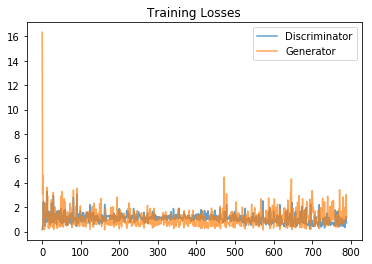

In [31]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)
    plot_losses(losses)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。